## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
import scipy.stats as stats
from scipy.stats import pearsonr, stats, chi2_contingency

warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Data Preprocessing

## Loading the Dataset

In [2]:
df = pd.read_csv("PCOS_data_without_infertility.csv")

In [3]:
df

Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  \
0         1                 1           0          28         44.6   
1         2                 2           0          36         65.0   
2         3                 3           1          33         68.8   
3         4                 4           0          37         65.0   
4         5                 5           0          25         52.0   
..      ...               ...         ...         ...          ...   
536     537               537           0          35         50.0   
537     538               538           0          30         63.2   
538     539               539           0          36         54.0   
539     540               540           0          27         50.0   
540     541               541           1          23         82.0   

     Height(Cm)      BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  \
0        152.000    19.3           15                78                22   
1        161.500  #NAME?           15                74                20   
2        165.000  #NAME?           11                72                18   
3        148.000  #NAME?           13                72                20   
4        161.000  #NAME?           11                72                18   
..           ...     ...          ...               ...               ...   
536      164.592    18.5           17                72                16   
537      158.000    25.3           15                72                18   
538      152.000    23.4           13                74                20   
539      150.000    22.2           15                74                20   
540      165.000    30.1           13                80                20   

     ...  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0    ...              1.0                  0                  110   
1    ...              0.0                  0                  120   
2    ...              1.0                  0                  120   
3    ...              0.0                  0                  120   
4    ...              0.0                  0                  120   
..   ...              ...                ...                  ...   
536  ...              0.0                  0                  110   
537  ...              0.0                  0                  110   
538  ...              0.0                  0                  110   
539  ...              0.0                  0                  110   
540  ...              1.0                  0                  120   

     BP _Diastolic (mmHg)  Follicle No. (L)  Follicle No. (R)  \
0                      80                 3                 3   
1                      70                 3                 5   
2                      80                13                15   
3                      70                 2                 2   
4                      80                 3                 4   
..                    ...               ...               ...   
536                    70                 1                 0   
537                    70                 9                 7   
538                    80                 1                 0   
539                    70                 7                 6   
540                    70                 9                10   

     Avg. F size (L) (mm) Avg. F size (R) (mm)  Endometrium (mm)  Unnamed: 44  
0                    18.0                 18.0               8.5          NaN  
1                    15.0                 14.0               3.7          NaN  
2                    18.0                 20.0              10.0          NaN  
3                    15.0                 14.0               7.5          NaN  
4                    16.0                 14.0               7.0          NaN  
..                    ...                  ...               ...          ...  
536                  17.5                 10.0               6.7     

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    object 
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

## Removing & Renaming Columns

In [5]:
df.columns = df.columns.str.strip()

In [6]:
df = df.drop(columns=["Marraige Status (Yrs)", "BMI", "Unnamed: 44", "Sl. No"])

In [7]:
df["BMI"] = (df["Weight (Kg)"] / ((df["Height(Cm)"] / 100) ** 2)).round(2)

# Insert BMI after "Height(Cm)"
df.insert(df.columns.get_loc("Height(Cm)") + 1, "BMI", df.pop("BMI"))

In [8]:
df

Patient File No.  PCOS (Y/N)  Age (yrs)  Weight (Kg)  Height(Cm)    BMI  \
0                   1           0         28         44.6     152.000  19.30   
1                   2           0         36         65.0     161.500  24.92   
2                   3           1         33         68.8     165.000  25.27   
3                   4           0         37         65.0     148.000  29.67   
4                   5           0         25         52.0     161.000  20.06   
..                ...         ...        ...          ...         ...    ...   
536               537           0         35         50.0     164.592  18.46   
537               538           0         30         63.2     158.000  25.32   
538               539           0         36         54.0     152.000  23.37   
539               540           0         27         50.0     150.000  22.22   
540               541           1         23         82.0     165.000  30.12   

     Blood Group  Pulse rate(bpm)  RR (breaths/min)  Hb(g/dl)  ...  \
0             15               78                22     10.48  ...   
1             15               74                20     11.70  ...   
2             11               72                18     11.80  ...   
3             13               72                20     12.00  ...   
4             11               72                18     10.00  ...   
..           ...              ...               ...       ...  ...   
536           17               72                16     11.00  ...   
537           15               72                18     10.80  ...   
538           13               74                20     10.80  ...   
539           15               74                20     12.00  ...   
540           13               80                20     10.20  ...   

     Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0               0              1.0                  0                  110   
1               0              0.0                  0                  120   
2               1              1.0                  0                  120   
3               0              0.0                  0                  120   
4               0              0.0                  0                  120   
..            ...              ...                ...                  ...   
536             0              0.0                  0                  110   
537             0              0.0                  0                  110   
538             0              0.0                  0                  110   
539             1              0.0                  0                  110   
540             1              1.0                  0                  120   

     BP _Diastolic (mmHg) Follicle No. (L)  Follicle No. (R)  \
0                      80                3                 3   
1                      70                3                 5   
2                      80               13                15   
3                      70                2                 2   
4                      80                3                 4   
..                    ...              ...               ...   
536                    70                1                 0   
537                    70                9                 7   
538                    80                1                 0   
539                    70                7                 6   
540                    70                9                10   

     Avg. F size (L) (mm) Avg. F size (R) (mm)  Endometrium (mm)  
0                    18.0                 18.0               8.5  
1                    15.0                 14.0               3.7  
2                    18.0                 20.0              10.0  
3                    15.0                 14.0               7.5  
4                    16.0                 14.0               7.0  
..                    ...                  ...               ...  
536                  17.5   

In [9]:
df.describe()

Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)  \
count        541.000000  541.000000  541.000000   541.000000  541.000000   
mean         271.000000    0.327172   31.430684    59.637153  156.484835   
std          156.317519    0.469615    5.411006    11.028287    6.033545   
min            1.000000    0.000000   20.000000    31.000000  137.000000   
25%          136.000000    0.000000   28.000000    52.000000  152.000000   
50%          271.000000    0.000000   31.000000    59.000000  156.000000   
75%          406.000000    1.000000   35.000000    65.000000  160.000000   
max          541.000000    1.000000   48.000000   108.000000  180.000000   

              BMI  Blood Group  Pulse rate(bpm)  RR (breaths/min)    Hb(g/dl)  \
count  541.000000   541.000000       541.000000        541.000000  541.000000   
mean    24.319427    13.802218        73.247689         19.243993   11.160037   
std      4.050917     1.840812         4.430285          1.688629    0.866904   
min     12.420000    11.000000        13.000000         16.000000    8.500000   
25%     21.710000    13.000000        72.000000         18.000000   10.500000   
50%     24.240000    14.000000        72.000000         18.000000   11.000000   
75%     26.640000    15.000000        74.000000         20.000000   11.700000   
max     38.900000    18.000000        82.000000         28.000000   14.800000   

       ...  Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  \
count  ...    541.000000       540.000000         541.000000   
mean   ...      0.489834         0.514815           0.247689   
std    ...      0.500359         0.500244           0.432070   
min    ...      0.000000         0.000000           0.000000   
25%    ...      0.000000         0.000000           0.000000   
50%    ...      0.000000         1.000000           0.000000   
75%    ...      1.000000         1.000000           0.000000   
max    ...      1.000000         1.000000           1.000000   

       BP _Systolic (mmHg)  BP _Diastolic (mmHg)  Follicle No. (L)  \
count           541.000000            541.000000        541.000000   
mean            114.661738             76.927911          6.129390   
std               7.384556              5.574112          4.229294   
min              12.000000              8.000000          0.000000   
25%             110.000000             70.000000          3.000000   
50%             110.000000             80.000000          5.000000   
75%             120.000000             80.000000          9.000000   
max             140.000000            100.000000         22.000000   

       Follicle No. (R)  Avg. F size (L) (mm)  Avg. F size (R) (mm)  \
count        541.000000            541.000000            541.000000   
mean           6.641405             15.018115             15.451701   
std            4.436889              3.566839              3.318848   
min            0.000000              0.000000              0.000000   
25%            3.000000             13.000000             13.000000   
50%            6.000000             15.000000             16.000000   
75%           10.000000             18.000000             18.000000   
max           20.000000             24.000000             24.000000   

       Endometrium (mm)  
count        541.000000  
mean           8.475915  
std            2.165381  
min            0.000000  
25%            7.000000  
50%            8.500000  
75%            9.800000  
max           18.000000  

[8 rows x 38 columns]

## Checking For Null Values & Handling Missing Values

In [10]:
df.isnull()

Patient File No.  PCOS (Y/N)  Age (yrs)  Weight (Kg)  Height(Cm)    BMI  \
0               False       False      False        False       False  False   
1               False       False      False        False       False  False   
2               False       False      False        False       False  False   
3               False       False      False        False       False  False   
4               False       False      False        False       False  False   
..                ...         ...        ...          ...         ...    ...   
536             False       False      False        False       False  False   
537             False       False      False        False       False  False   
538             False       False      False        False       False  False   
539             False       False      False        False       False  False   
540             False       False      False        False       False  False   

     Blood Group  Pulse rate(bpm)  RR (breaths/min)  Hb(g/dl)  ...  \
0          False            False             False     False  ...   
1          False            False             False     False  ...   
2          False            False             False     False  ...   
3          False            False             False     False  ...   
4          False            False             False     False  ...   
..           ...              ...               ...       ...  ...   
536        False            False             False     False  ...   
537        False            False             False     False  ...   
538        False            False             False     False  ...   
539        False            False             False     False  ...   
540        False            False             False     False  ...   

     Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0           False            False              False                False   
1           False            False              False                False   
2           False            False              False                False   
3           False            False              False                False   
4           False            False              False                False   
..            ...              ...                ...                  ...   
536         False            False              False                False   
537         False            False              False                False   
538         False            False              False                False   
539         False            False              False                False   
540         False            False              False                False   

     BP _Diastolic (mmHg)  Follicle No. (L)  Follicle No. (R)  \
0                   False             False             False   
1                   False             False             False   
2                   False             False             False   
3                   False             False             False   
4                   False             False             False   
..                    ...               ...               ...   
536                 False             False             False   
537                 False             False             False   
538                 False             False             False   
539                 False             False             False   
540                 False             False             False   

     Avg. F size (L) (mm)  Avg. F size (R) (mm)  Endometrium (mm)  
0                   False                 False             False  
1                   False                 False             False  
2                   False                 False             False  
3                   False                 False             False  
4                   False                 False             False  
..                    ...                   ...               ...  
536      

In [11]:
df = df.dropna()
print("Null values after dropping:", df.isnull().sum().sum())

Null values after dropping: 0


In [12]:
df

Patient File No.  PCOS (Y/N)  Age (yrs)  Weight (Kg)  Height(Cm)    BMI  \
0                   1           0         28         44.6     152.000  19.30   
1                   2           0         36         65.0     161.500  24.92   
2                   3           1         33         68.8     165.000  25.27   
3                   4           0         37         65.0     148.000  29.67   
4                   5           0         25         52.0     161.000  20.06   
..                ...         ...        ...          ...         ...    ...   
536               537           0         35         50.0     164.592  18.46   
537               538           0         30         63.2     158.000  25.32   
538               539           0         36         54.0     152.000  23.37   
539               540           0         27         50.0     150.000  22.22   
540               541           1         23         82.0     165.000  30.12   

     Blood Group  Pulse rate(bpm)  RR (breaths/min)  Hb(g/dl)  ...  \
0             15               78                22     10.48  ...   
1             15               74                20     11.70  ...   
2             11               72                18     11.80  ...   
3             13               72                20     12.00  ...   
4             11               72                18     10.00  ...   
..           ...              ...               ...       ...  ...   
536           17               72                16     11.00  ...   
537           15               72                18     10.80  ...   
538           13               74                20     10.80  ...   
539           15               74                20     12.00  ...   
540           13               80                20     10.20  ...   

     Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  BP _Systolic (mmHg)  \
0               0              1.0                  0                  110   
1               0              0.0                  0                  120   
2               1              1.0                  0                  120   
3               0              0.0                  0                  120   
4               0              0.0                  0                  120   
..            ...              ...                ...                  ...   
536             0              0.0                  0                  110   
537             0              0.0                  0                  110   
538             0              0.0                  0                  110   
539             1              0.0                  0                  110   
540             1              1.0                  0                  120   

     BP _Diastolic (mmHg) Follicle No. (L)  Follicle No. (R)  \
0                      80                3                 3   
1                      70                3                 5   
2                      80               13                15   
3                      70                2                 2   
4                      80                3                 4   
..                    ...              ...               ...   
536                    70                1                 0   
537                    70                9                 7   
538                    80                1                 0   
539                    70                7                 6   
540                    70                9                10   

     Avg. F size (L) (mm) Avg. F size (R) (mm)  Endometrium (mm)  
0                    18.0                 18.0               8.5  
1                    15.0                 14.0               3.7  
2                    18.0                 20.0              10.0  
3                    15.0                 14.0               7.5  
4                    16.0                 14.0               7.0  
..                    ...                  ...               ...  
536                  17.5   

In [13]:
df.isnull().sum()

Patient File No.          0
PCOS (Y/N)                0
Age (yrs)                 0
Weight (Kg)               0
Height(Cm)                0
BMI                       0
Blood Group               0
Pulse rate(bpm)           0
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Pregnant(Y/N)             0
No. of aborptions         0
I   beta-HCG(mIU/mL)      0
II    beta-HCG(mIU/mL)    0
FSH(mIU/mL)               0
LH(mIU/mL)                0
FSH/LH                    0
Hip(inch)                 0
Waist(inch)               0
Waist:Hip Ratio           0
TSH (mIU/L)               0
AMH(ng/mL)                0
PRL(ng/mL)                0
Vit D3 (ng/mL)            0
PRG(ng/mL)                0
RBS(mg/dl)                0
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           0
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg) 

## Hypothesis Testing
T-test (Welch’s T-test)

In [14]:
numerical_columns = [
    "Age (yrs)", "Weight (Kg)", "Height(Cm)", "BMI", "Pulse rate(bpm)",
    "RR (breaths/min)", "Hb(g/dl)", "Cycle length(days)", "I   beta-HCG(mIU/mL)", 
    "II    beta-HCG(mIU/mL)", "FSH(mIU/mL)", "LH(mIU/mL)", "FSH/LH", "Hip(inch)", 
    "Waist(inch)", "Waist:Hip Ratio", "TSH (mIU/L)", "AMH(ng/mL)", "PRL(ng/mL)", 
    "Vit D3 (ng/mL)", "PRG(ng/mL)", "RBS(mg/dl)", "BP _Systolic (mmHg)", 
    "BP _Diastolic (mmHg)", "Follicle No. (L)", "Follicle No. (R)", 
    "Avg. F size (L) (mm)", "Avg. F size (R) (mm)", "Endometrium (mm)"
]
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

for col in numerical_columns:
    pcos_group = df[df["PCOS (Y/N)"] == 1][col].dropna()
    non_pcos_group = df[df["PCOS (Y/N)"] == 0][col].dropna()

    t_stat, p_value = stats.ttest_ind(pcos_group, non_pcos_group, equal_var=False)
    print(f"{col}: T-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print(f"→ {col} has a statistically significant difference between PCOS and non-PCOS groups.\n")
    else:
        print(f"→ No significant difference in {col} between PCOS and non-PCOS groups.\n")

Age (yrs): T-statistic = -4.01, p-value = 0.0001
→ Age (yrs) has a statistically significant difference between PCOS and non-PCOS groups.

Weight (Kg): T-statistic = 4.70, p-value = 0.0000
→ Weight (Kg) has a statistically significant difference between PCOS and non-PCOS groups.

Height(Cm): T-statistic = 1.58, p-value = 0.1161
→ No significant difference in Height(Cm) between PCOS and non-PCOS groups.

BMI: T-statistic = 4.47, p-value = 0.0000
→ BMI has a statistically significant difference between PCOS and non-PCOS groups.

Pulse rate(bpm): T-statistic = 2.58, p-value = 0.0102
→ Pulse rate(bpm) has a statistically significant difference between PCOS and non-PCOS groups.

RR (breaths/min): T-statistic = 0.92, p-value = 0.3583
→ No significant difference in RR (breaths/min) between PCOS and non-PCOS groups.

Hb(g/dl): T-statistic = 2.05, p-value = 0.0411
→ Hb(g/dl) has a statistically significant difference between PCOS and non-PCOS groups.

Cycle length(days): T-statistic = -3.75, p-

**The following will be utilized in the numerical features EDA as it shows a statistically significant difference between PCOS and non-PCOS groups.**

Age (yrs)\
Weight (Kg) \
BMI \
Pulse rate (bpm) \
Hb (g/dl) \
Cycle length (days) \
Hip (inch) \
Waist (inch) \
AMH (ng/mL) \
Follicle No. (L) \
Follicle No. (R) \
Avg. F size (L) (mm) \
Avg. F size (R) (mm) \
Endometrium (mm)

## Exploratory Data Analysis

### Categorical Features

PCOS (Y/N)
0    363
1    177
Name: count, dtype: int64


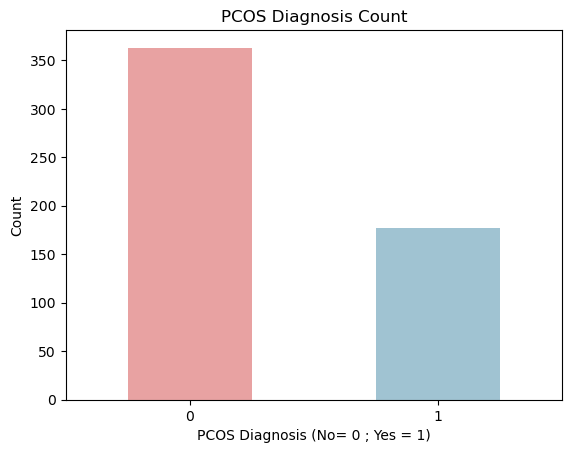

In [15]:
df["PCOS (Y/N)"].value_counts().plot(kind="bar", color=["#e8a2a2", "#a0c3d2"])
plt.xlabel("PCOS Diagnosis (No= 0 ; Yes = 1)")
plt.ylabel("Count")
plt.title("PCOS Diagnosis Count")
plt.xticks(rotation = 0)
pcos_counts = df["PCOS (Y/N)"].value_counts()
print(pcos_counts)
plt.show()

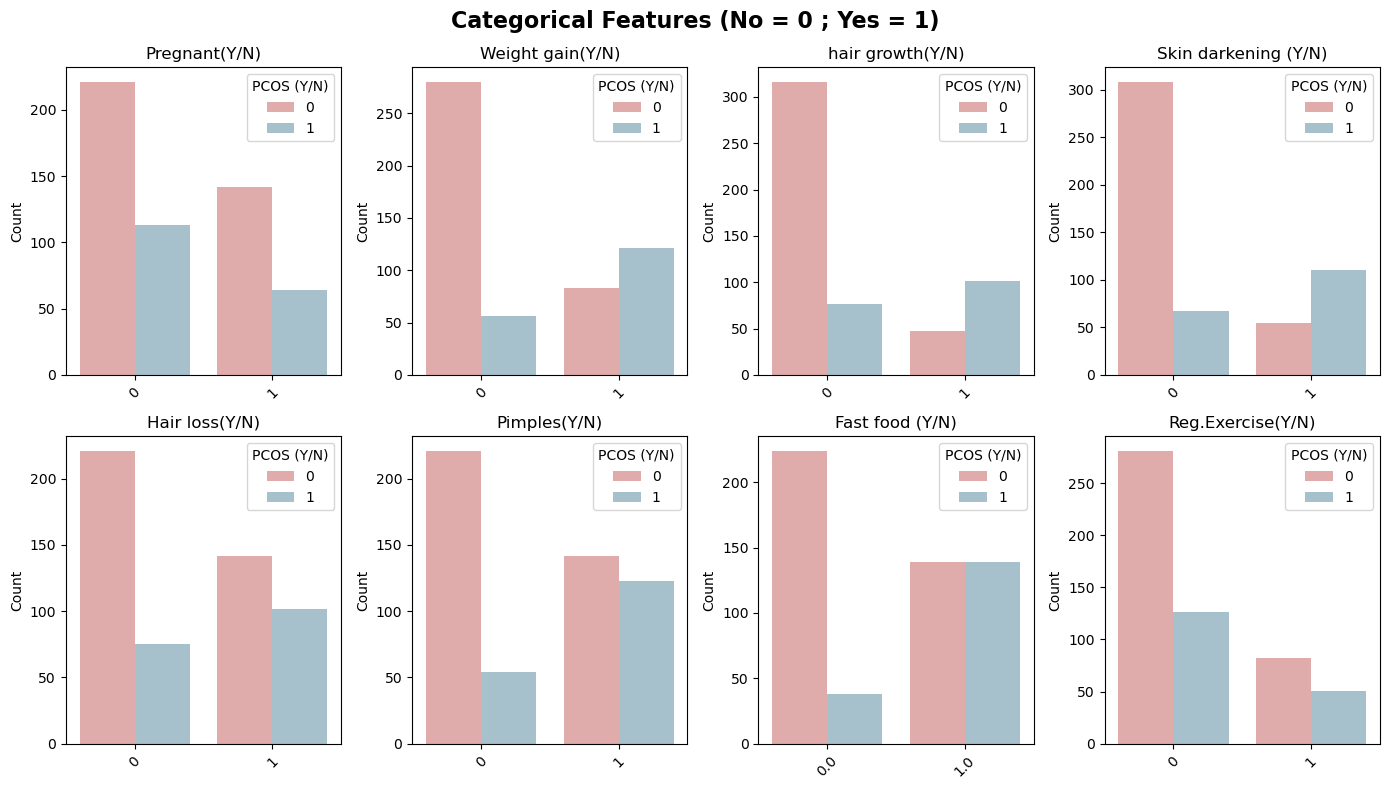

In [16]:
categorical_features = ["Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", 
                        "Hair loss(Y/N)",  "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)"]

plt.figure(figsize=(14, 8))
plt.suptitle("Categorical Features (No = 0 ; Yes = 1)", fontsize=16, fontweight="bold")

for i, col in enumerate(categorical_features):
    plt.subplot(2, 4, i+1)
    sns.countplot(x=df[col], hue=df["PCOS (Y/N)"], palette=["#e8a2a2", "#a0c3d2"])
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Numerical Features

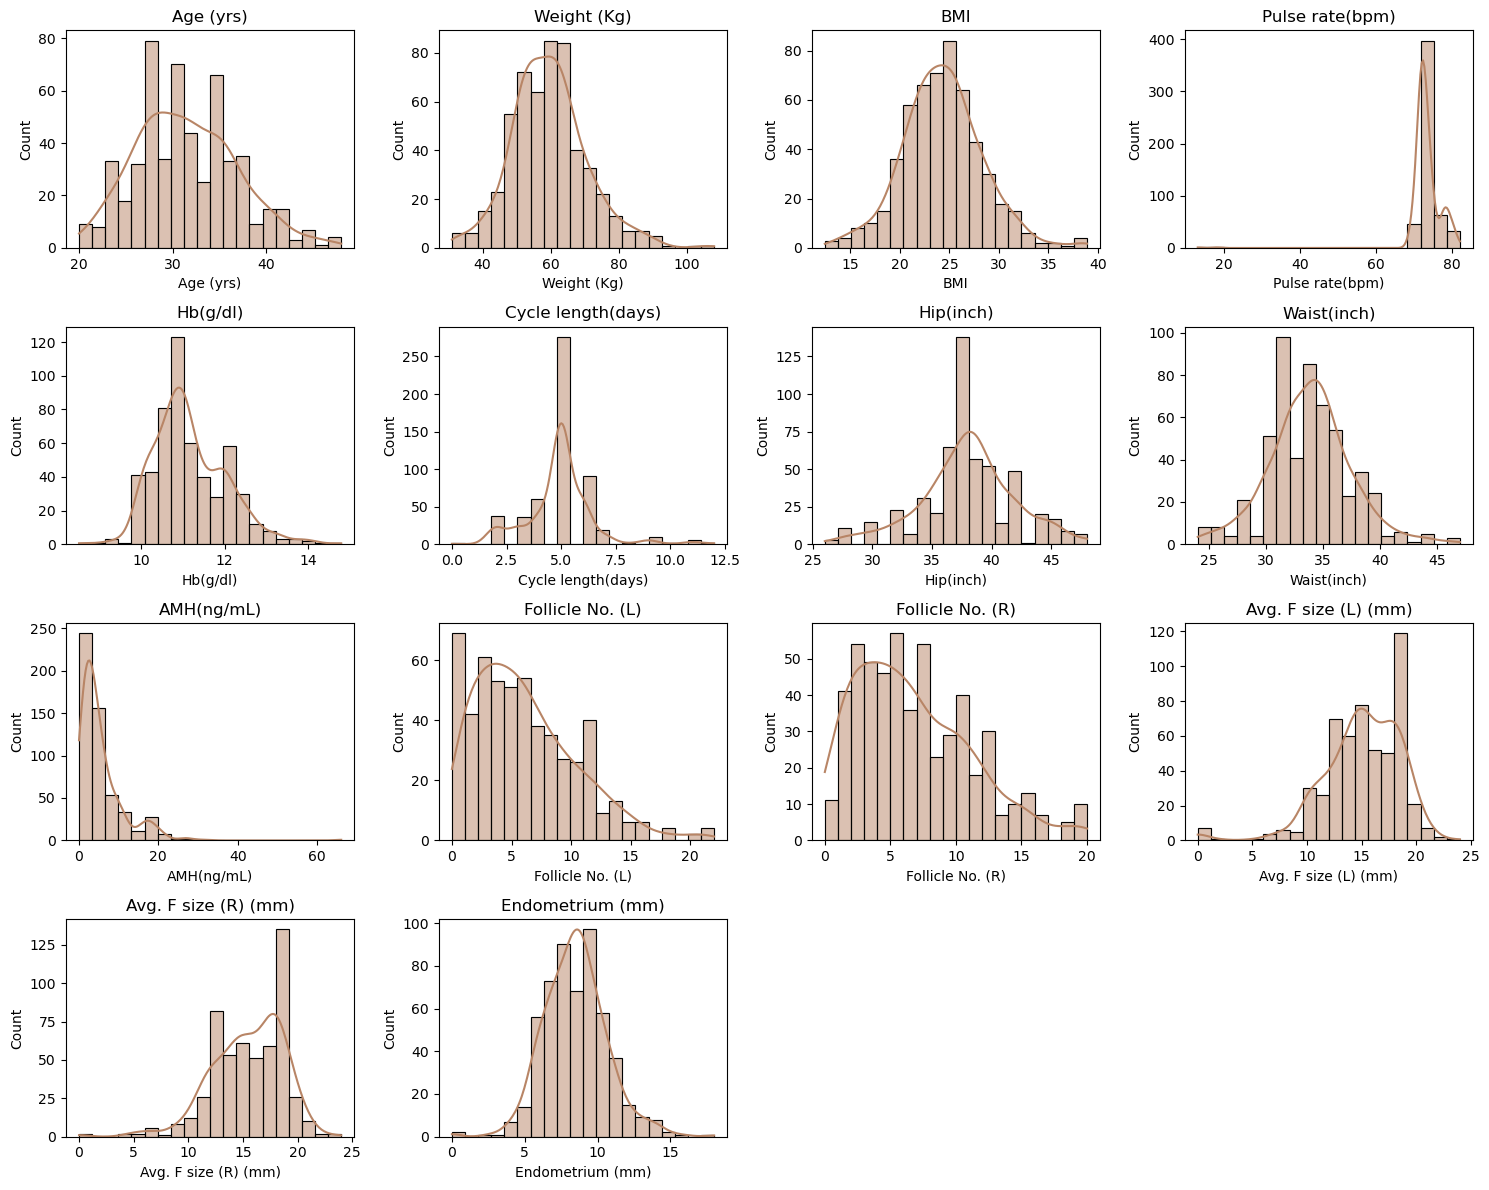

In [17]:
numerical_features = [
    "Age (yrs)", "Weight (Kg)", "BMI", "Pulse rate(bpm)", "Hb(g/dl)", 
    "Cycle length(days)", "Hip(inch)", "Waist(inch)", "AMH(ng/mL)", 
    "Follicle No. (L)", "Follicle No. (R)", "Avg. F size (L) (mm)", 
    "Avg. F size (R) (mm)", "Endometrium (mm)"
]

plt.figure(figsize=(15, 12))  
rows, cols = 4, 4 

for i, col in enumerate(numerical_features):
    plt.subplot(rows, cols, i + 1)  
    if col in df.columns:  
        sns.histplot(df[col], bins=20, kde=True, color="#b88566", line_kws={'color': '#b88566'})
        plt.title(col)
    else:
        print(f"Column '{col}' not found in DataFrame.")

plt.tight_layout()
plt.show()

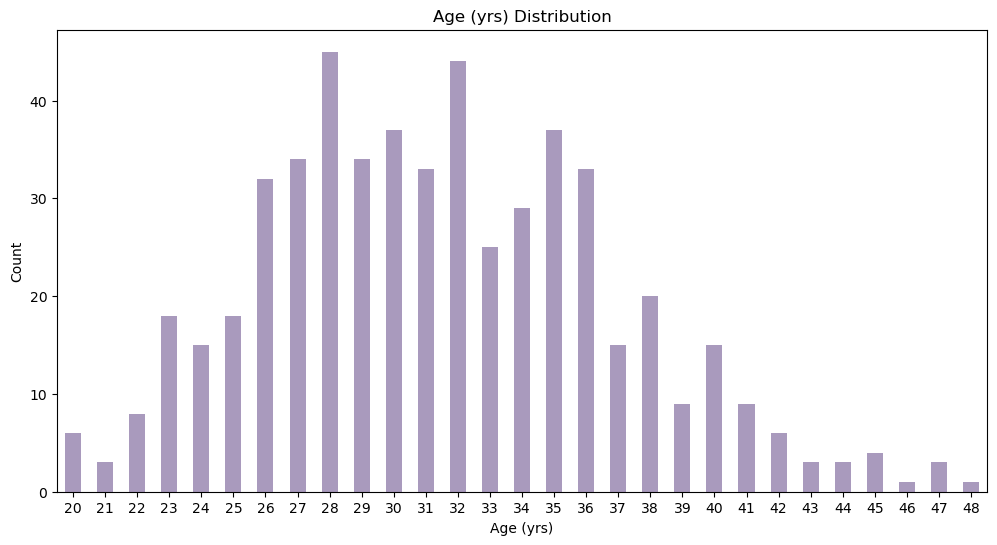

In [18]:
age_counts = df["Age (yrs)"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
age_counts.plot(kind="bar", color="#a99abd")
plt.xlabel("Age (yrs)")
plt.ylabel("Count")
plt.title("Age (yrs) Distribution")
plt.xticks(rotation=0) 
plt.show()

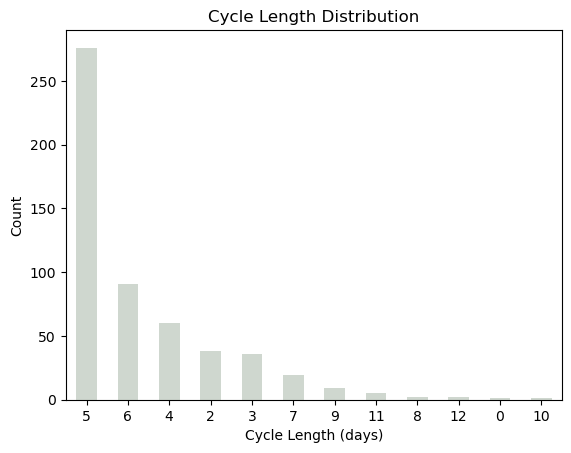

In [19]:
cycle_counts = df["Cycle length(days)"].value_counts()
cycle_counts.plot(kind="bar", color="#cfd7cf")
plt.xlabel("Cycle Length (days)")
plt.ylabel("Count")
plt.title("Cycle Length Distribution")
plt.xticks(rotation=0)  
plt.show()

### Heat Map

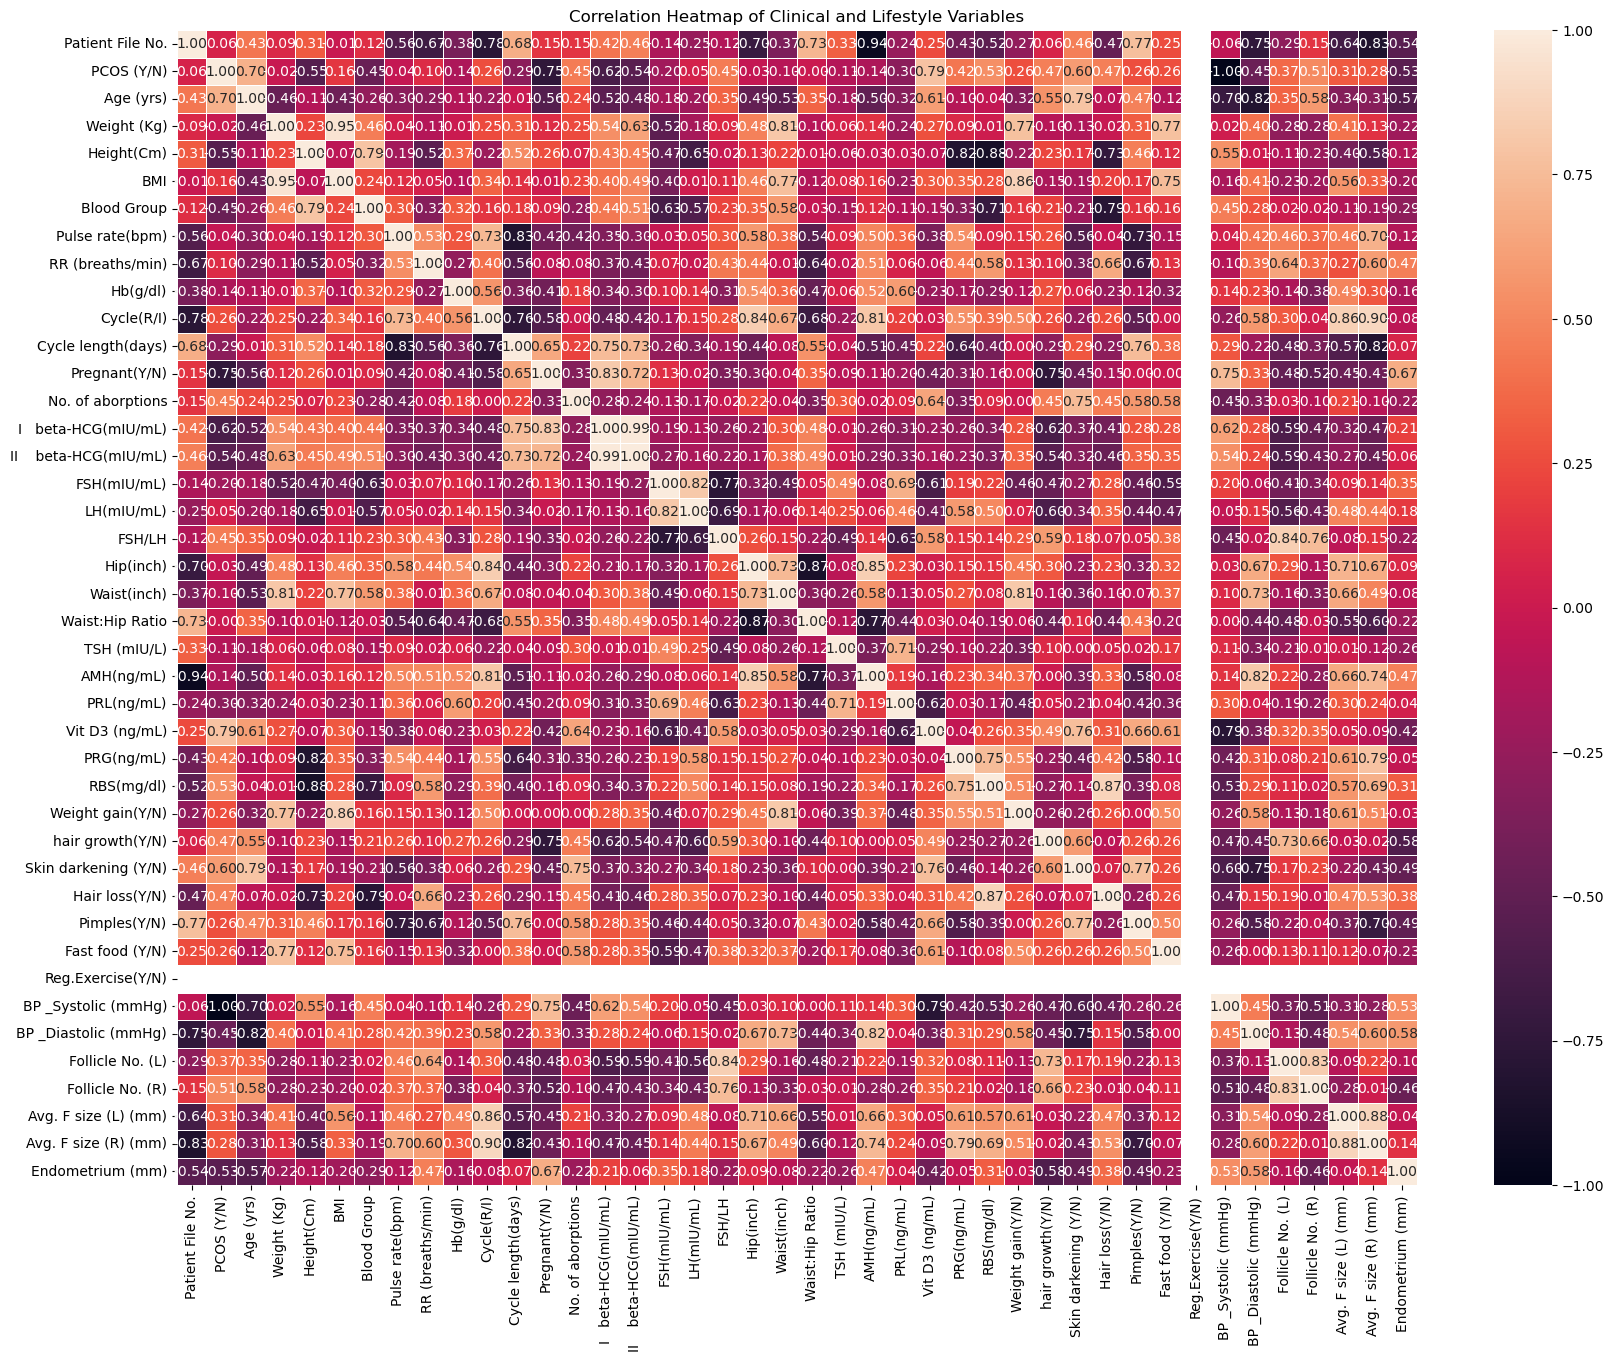

In [20]:
# Convert all numeric columns to float, coerce errors to NaN
df_numeric = df.apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN values before computing correlation
df_numeric = df_numeric.dropna()

# Compute correlation
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="rocket", linewidths=0.5)
plt.title("Correlation Heatmap of Clinical and Lifestyle Variables")
plt.show()

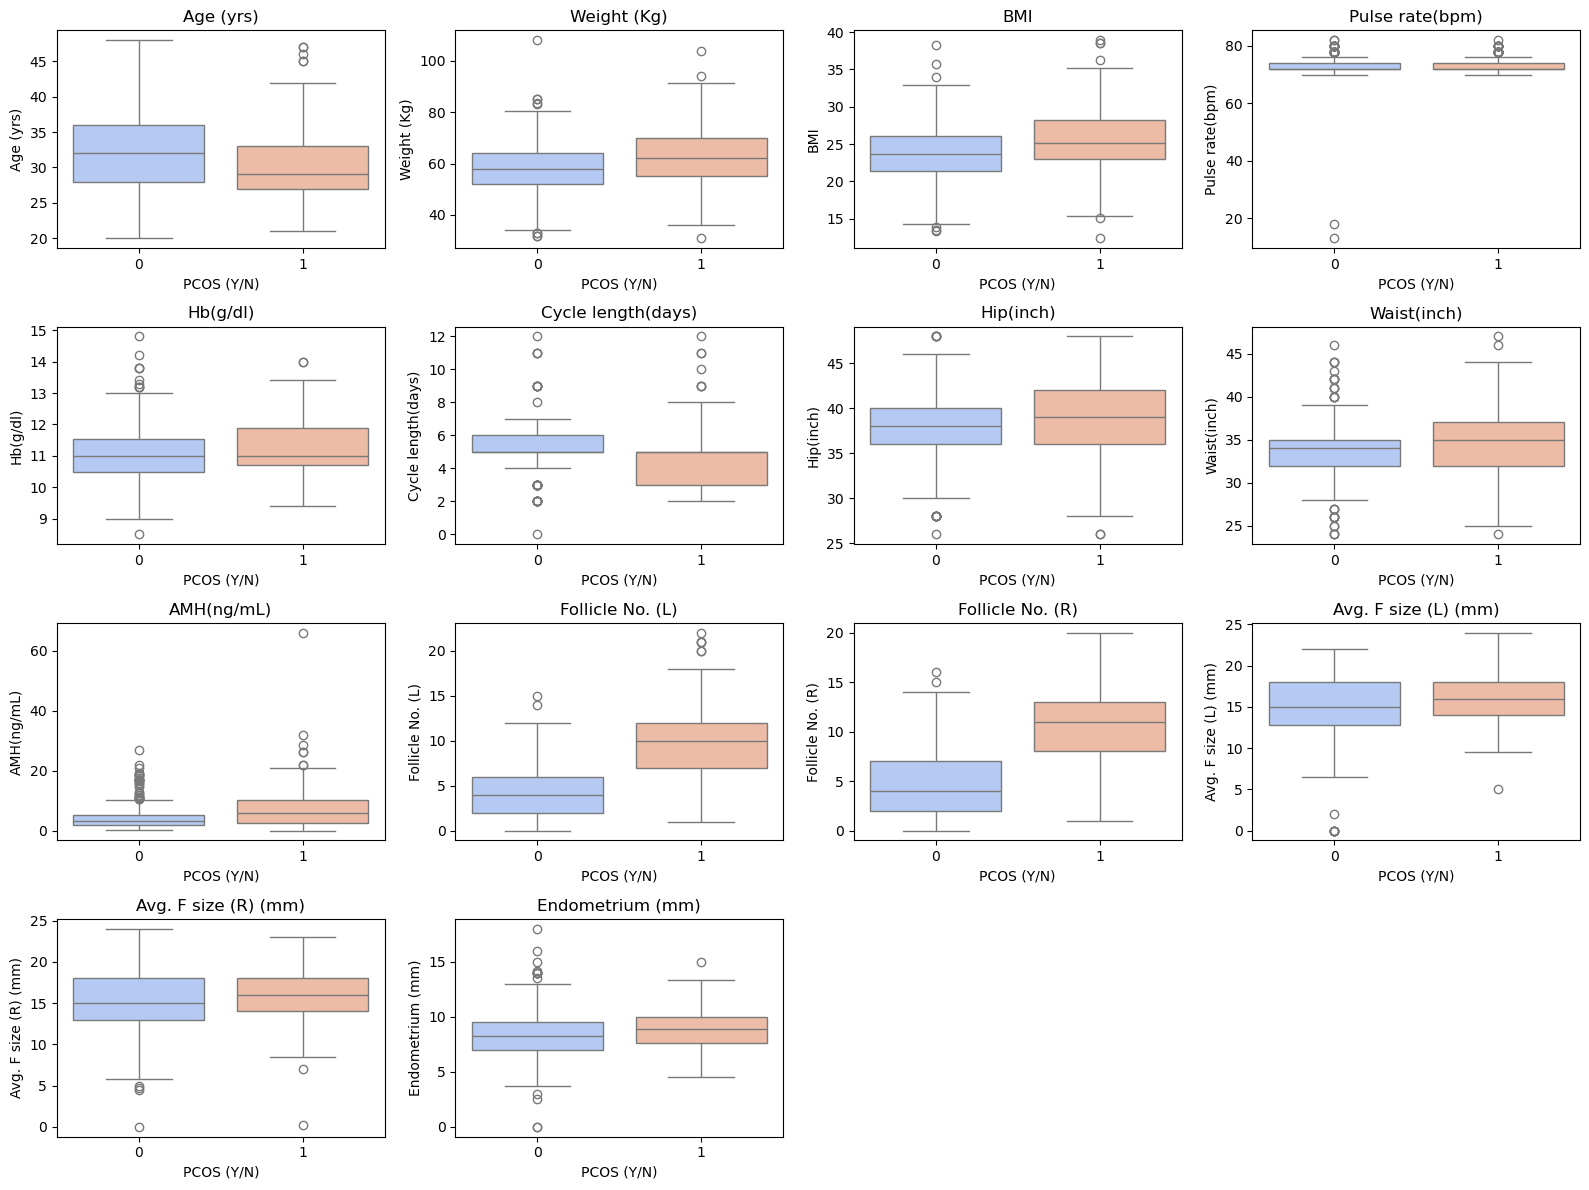

In [21]:
plt.figure(figsize=(16, 12))
rows, cols = 4, 4  
for i, col in enumerate(numerical_features):
    plt.subplot(rows, cols, i + 1)  
    sns.boxplot(x=df["PCOS (Y/N)"], y=df[col], palette="coolwarm") 
    plt.title(col)
plt.tight_layout()
plt.show()

# Feature Selection

## Chi-Sqaure Test 

*For categorical vs target*

In [22]:
categorical_features = ["Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", 
                        "Skin darkening (Y/N)", "Hair loss(Y/N)", "Pimples(Y/N)", 
                        "Fast food (Y/N)", "Reg.Exercise(Y/N)"]
target = "PCOS (Y/N)"

In [23]:
chi2_results = {}
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df[target])

    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results[feature] = p_value

chi2_df = pd.DataFrame(list(chi2_results.items()), columns=["Feature", "P-Value"])
chi2_df["Significant"] = chi2_df["P-Value"] < 0.05  
chi2_df.reset_index(drop=True, inplace=True)
print(chi2_df)
print(chi2_df.sort_values(by="P-Value"))

                Feature       P-Value  Significant
0         Pregnant(Y/N)  5.684147e-01        False
1      Weight gain(Y/N)  3.616293e-24         True
2      hair growth(Y/N)  1.192433e-26         True
3  Skin darkening (Y/N)  2.771343e-28         True
4        Hair loss(Y/N)  7.352571e-05         True
5          Pimples(Y/N)  6.335439e-11         True
6       Fast food (Y/N)  3.603668e-18         True
7     Reg.Exercise(Y/N)  1.417369e-01        False
                Feature       P-Value  Significant
3  Skin darkening (Y/N)  2.771343e-28         True
2      hair growth(Y/N)  1.192433e-26         True
1      Weight gain(Y/N)  3.616293e-24         True
6       Fast food (Y/N)  3.603668e-18         True
5          Pimples(Y/N)  6.335439e-11         True
4        Hair loss(Y/N)  7.352571e-05         True
7     Reg.Exercise(Y/N)  1.417369e-01        False
0         Pregnant(Y/N)  5.684147e-01        False


**Interpretation:** \
p-value < 0.05 → Feature is significantly associated with PCOS (Y/N) (keep it). \
p-value ≥ 0.05 → No strong statistical relationship (consider removing it).

## ANOVA (F-test)
*For categorical vs target*

In [24]:
numerical_features = [
    "Age (yrs)", "Weight (Kg)", "BMI", "Pulse rate(bpm)", "Hb(g/dl)", 
    "Cycle length(days)", "Hip(inch)", "Waist(inch)", "AMH(ng/mL)", 
    "Follicle No. (L)", "Follicle No. (R)", "Avg. F size (L) (mm)", 
    "Avg. F size (R) (mm)", "Endometrium (mm)"
]
target = "PCOS (Y/N)"

# Perform ANOVA test
anova_results = {}
for feature in numerical_features:
    # Split data into PCOS = 1 and PCOS = 0 groups
    group1 = df[df[target] == 1][feature]  # PCOS positive
    group0 = df[df[target] == 0][feature]  # PCOS negative
    
    # Perform F-test (ANOVA)
    f_stat, p_value = stats.f_oneway(group1, group0)
    anova_results[feature] = p_value

anova_df = pd.DataFrame(list(anova_results.items()), columns=["Feature", "P-Value"])
anova_df["Significant"] = anova_df["P-Value"] < 0.05 

print(anova_df.sort_values(by="P-Value"))

                 Feature       P-Value  Significant
10      Follicle No. (R)  8.213165e-66         True
9       Follicle No. (L)  7.707835e-55         True
1            Weight (Kg)  7.198394e-07         True
2                    BMI  3.016400e-06         True
5     Cycle length(days)  2.737325e-05         True
0              Age (yrs)  7.358959e-05         True
7            Waist(inch)  1.285006e-04         True
6              Hip(inch)  1.554815e-04         True
11  Avg. F size (L) (mm)  2.155837e-03         True
13      Endometrium (mm)  1.176267e-02         True
12  Avg. F size (R) (mm)  2.443973e-02         True
3        Pulse rate(bpm)  3.351114e-02         True
4               Hb(g/dl)  4.508597e-02         True
8             AMH(ng/mL)           NaN        False


**Interpretation:**\
p-value < 0.05 → Feature is significantly different between PCOS and non-PCOS (important for the model).\
p-value ≥ 0.05 → No strong statistical difference (consider removing it). 

## Pearson Correlation

*For numerical features*

In [25]:
numerical_features = [
    "Age (yrs)", "Weight (Kg)", "BMI", "Pulse rate(bpm)", "Hb(g/dl)", 
    "Cycle length(days)", "Hip(inch)", "Waist(inch)", "Follicle No. (L)", 
    "Follicle No. (R)", "Avg. F size (L) (mm)", 
    "Avg. F size (R) (mm)", "Endometrium (mm)"
]
target = "PCOS (Y/N)"
pearson_results = {}
for feature in numerical_features:
    corr, p_value = stats.pearsonr(df[feature], df[target])
    pearson_results[feature] = (corr, p_value)

pearson_df = pd.DataFrame.from_dict(pearson_results, orient="index", columns=["Correlation", "P-Value"])
pearson_df["Significant"] = pearson_df["P-Value"] < 0.05 
print(pearson_df.sort_values(by="Correlation", ascending=False))

                      Correlation       P-Value  Significant
Follicle No. (R)         0.648728  8.213165e-66         True
Follicle No. (L)         0.603313  7.707835e-55         True
Weight (Kg)              0.211345  7.198394e-07         True
BMI                      0.199393  3.016400e-06         True
Waist(inch)              0.164050  1.285006e-04         True
Hip(inch)                0.162056  1.554815e-04         True
Avg. F size (L) (mm)     0.131750  2.155837e-03         True
Endometrium (mm)         0.108340  1.176267e-02         True
Avg. F size (R) (mm)     0.096828  2.443973e-02         True
Pulse rate(bpm)          0.091504  3.351114e-02         True
Hb(g/dl)                 0.086271  4.508597e-02         True
Age (yrs)               -0.169753  7.358959e-05         True
Cycle length(days)      -0.179442  2.737325e-05         True


**Interpretation:**\
Correlation close to ±1 → Strong linear relationship \
Correlation close to 0 → Weak/no linear relationship \
p-value < 0.05 → Statistically significant correlation

# Handling Outliers
*From the numerical Box Plot* - removing the column "AMH(ng/mL)" based from the results of ANOVA

In [26]:
df_cleaned = df.copy()

numerical_features = [
    "Age (yrs)", "Weight (Kg)", "BMI", "Pulse rate(bpm)", "Hb(g/dl)", 
    "Cycle length(days)", "Hip(inch)", "Waist(inch)", 
    "Follicle No. (L)", "Follicle No. (R)", "Avg. F size (L) (mm)", 
    "Avg. F size (R) (mm)", "Endometrium (mm)"
]

# IQR Method for Outlier Handling (Instead of Removing)
for col in numerical_features:
    Q1 = df_cleaned[col].quantile(0.25)  # 25th percentile
    Q3 = df_cleaned[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1 

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Alternative Handling 1: Cap the Outliers (Winsorization)
    df_cleaned[col] = np.where(df_cleaned[col] > upper_bound, upper_bound, df_cleaned[col])
    df_cleaned[col] = np.where(df_cleaned[col] < lower_bound, lower_bound, df_cleaned[col])

    # Alternative Handling 2: Apply Log Transformation for Skewed Data
    df_cleaned[col] = np.log1p(df_cleaned[col])  # log(1 + x) to handle zeros

print(f"Original Data Shape: {df.shape}")
print(f"Cleaned Data Shape: {df_cleaned.shape}")

Original Data Shape: (540, 42)
Cleaned Data Shape: (540, 42)


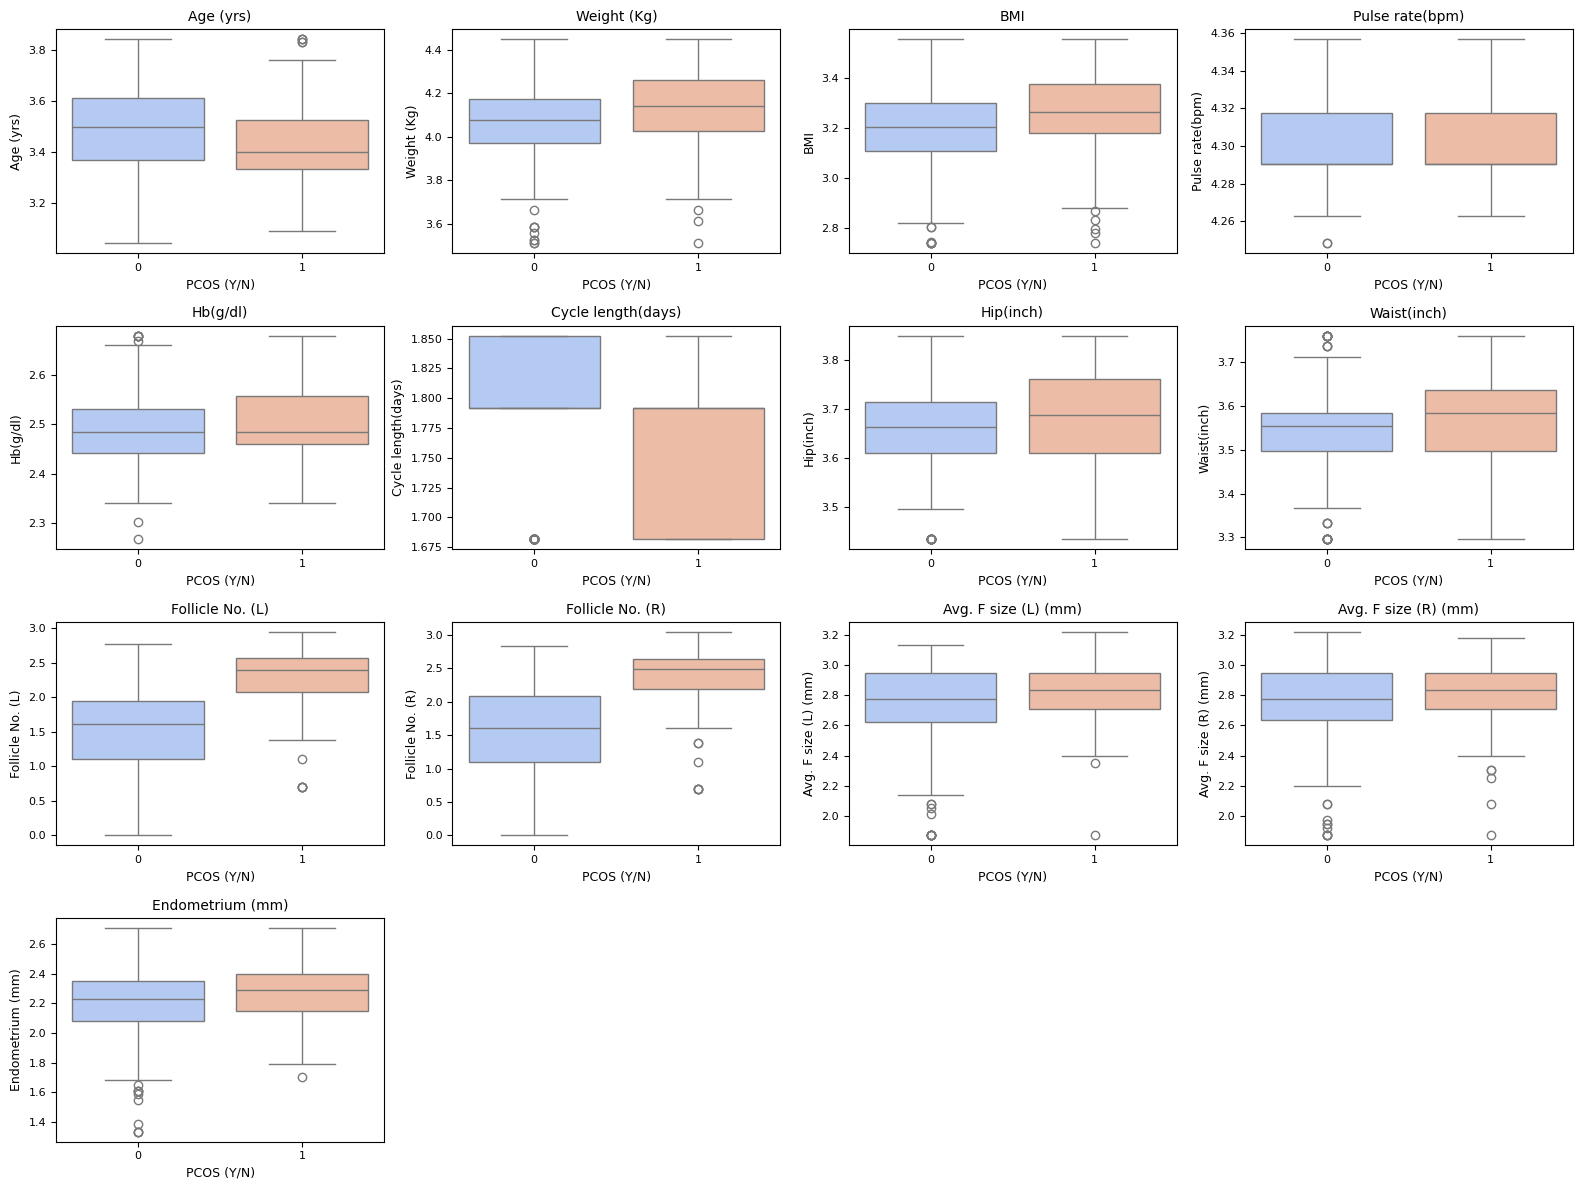

In [27]:
plt.figure(figsize=(16, 12))
rows, cols = 4, 4 

for i, col in enumerate(numerical_features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=df_cleaned["PCOS (Y/N)"], y=df_cleaned[col], palette="coolwarm", showfliers=True)  
    plt.title(col, fontsize=10)
    plt.xlabel("PCOS (Y/N)", fontsize=9)
    plt.ylabel(col, fontsize=9)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

# Data Standard Normalization

Machine learning models are very sensitive to the input variable scale, which can affect their performance. Therefore, data normalization is carried out using the standard scaling method. Standard scaling assigns a variable a zero mean value and 1 as the standard deviation.

Hence using a  StandardScaler (Z-score Normalization)

StandardScaler transforms data to have mean = 0 and standard deviation = 1.

In [28]:
numerical_features = [
    "Age (yrs)", "Weight (Kg)", "BMI", "Pulse rate(bpm)", "Hb(g/dl)", 
    "Cycle length(days)", "Hip(inch)", "Waist(inch)", 
    "Follicle No. (L)", "Follicle No. (R)", "Avg. F size (L) (mm)", 
    "Avg. F size (R) (mm)", "Endometrium (mm)"
]

scaler = StandardScaler()

df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])
df_cleaned[numerical_features].head()

Age (yrs)  Weight (Kg)       BMI  Pulse rate(bpm)  Hb(g/dl)  \
0  -0.588959    -1.498059 -1.312723         1.837173 -0.799663   
1   0.876655     0.575970  0.233038         0.425209  0.674671   
2   0.367963     0.889976  0.317872        -0.547836  0.789165   
3   1.037090     0.575970  1.297325        -0.547836  1.015496   
4  -1.245895    -0.654506 -1.080255        -0.547836 -1.423160   

   Cycle length(days)  Hip(inch)  Waist(inch)  Follicle No. (L)  \
0            0.213044  -0.499161    -1.123563         -0.595804   
1            0.213044   0.040001    -0.492969         -0.595804   
2            0.213044   0.552192     0.661000          1.337592   
3            0.213044   1.039985     0.661000         -1.039785   
4            0.213044  -0.226033    -1.123563         -0.595804   

   Follicle No. (R)  Avg. F size (L) (mm)  Avg. F size (R) (mm)  \
0         -0.697200              0.819580              0.741852   
1         -0.078889              0.077036             -0.323233   
2          1.416818              0.819580              1.192793   
3         -1.135898              0.077036             -0.323233   
4         -0.356919              0.338988             -0.323233   

   Endometrium (mm)  
0          0.125265  
1         -2.944598  
2          0.764790  
3         -0.359932  
4         -0.624394

In [29]:
df1 = df_cleaned[numerical_features] 

# Data Merged

In [30]:
df1 = df_cleaned[categorical_features + numerical_features + ["PCOS (Y/N)"]]

In [31]:
df1.head()

Pregnant(Y/N)  Weight gain(Y/N)  hair growth(Y/N)  Skin darkening (Y/N)  \
0              0                 0                 0                     0   
1              1                 0                 0                     0   
2              1                 0                 0                     0   
3              0                 0                 0                     0   
4              1                 0                 0                     0   

   Hair loss(Y/N)  Pimples(Y/N)  Fast food (Y/N)  Reg.Exercise(Y/N)  \
0               0             0              1.0                  0   
1               0             0              0.0                  0   
2               1             1              1.0                  0   
3               0             0              0.0                  0   
4               1             0              0.0                  0   

   Age (yrs)  Weight (Kg)  ...  Hb(g/dl)  Cycle length(days)  Hip(inch)  \
0  -0.588959    -1.498059  ... -0.799663            0.213044  -0.499161   
1   0.876655     0.575970  ...  0.674671            0.213044   0.040001   
2   0.367963     0.889976  ...  0.789165            0.213044   0.552192   
3   1.037090     0.575970  ...  1.015496            0.213044   1.039985   
4  -1.245895    -0.654506  ... -1.423160            0.213044  -0.226033   

   Waist(inch)  Follicle No. (L)  Follicle No. (R)  Avg. F size (L) (mm)  \
0    -1.123563         -0.595804         -0.697200              0.819580   
1    -0.492969         -0.595804         -0.078889              0.077036   
2     0.661000          1.337592          1.416818              0.819580   
3     0.661000         -1.039785         -1.135898              0.077036   
4    -1.123563         -0.595804         -0.356919              0.338988   

   Avg. F size (R) (mm)  Endometrium (mm)  PCOS (Y/N)  
0              0.741852          0.125265           0  
1             -0.323233         -2.944598           0  
2              1.192793          0.764790           1  
3             -0.323233         -0.359932           0  
4             -0.323233         -0.624394           0  

[5 rows x 22 columns]

In [32]:
list(df1.columns)

['Pregnant(Y/N)',
 'Weight gain(Y/N)',
 'hair growth(Y/N)',
 'Skin darkening (Y/N)',
 'Hair loss(Y/N)',
 'Pimples(Y/N)',
 'Fast food (Y/N)',
 'Reg.Exercise(Y/N)',
 'Age (yrs)',
 'Weight (Kg)',
 'BMI',
 'Pulse rate(bpm)',
 'Hb(g/dl)',
 'Cycle length(days)',
 'Hip(inch)',
 'Waist(inch)',
 'Follicle No. (L)',
 'Follicle No. (R)',
 'Avg. F size (L) (mm)',
 'Avg. F size (R) (mm)',
 'Endometrium (mm)',
 'PCOS (Y/N)']

# Data Augmentation & Splitting
Removing "Pregnant(Y/N)" and "Reg.Exercise(Y/N)" based from the feature selection of Chi-square. \
Removing AMH(ng/mL) based from the feature selection of ANOVA.

## Resampling on Complete Dataset

In [33]:
X = df1[['Weight gain(Y/N)',
         'hair growth(Y/N)',
         'Skin darkening (Y/N)',
         'Hair loss(Y/N)',
         'Pimples(Y/N)',
         'Fast food (Y/N)',
         'Age (yrs)',
         'Weight (Kg)',
         'BMI',
         'Pulse rate(bpm)',
         'Hb(g/dl)',
         'Cycle length(days)',
         'Hip(inch)',
         'Waist(inch)',
         'Follicle No. (L)',
         'Follicle No. (R)',
         'Avg. F size (L) (mm)',
         'Avg. F size (R) (mm)',
         'Endometrium (mm)']]

In [34]:
y = df1["PCOS (Y/N)"]

In [35]:
# Perform 80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [36]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

  File "C:\Users\adief\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\adief\AppData\Local\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\adief\AppData\Local\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\adief\AppData\Local\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [37]:
print(y_train_smote.value_counts())

PCOS (Y/N)
0    290
1    290
Name: count, dtype: int64


**After applying SMOTE, the training set now has 290 samples for both classes (PCOS=0 and PCOS=1)**

# Model Development

## Random Forest

In [38]:
# Apply 50-fold Cross-Validation within the 80% training set
kf = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

In [39]:
rf = RandomForestClassifier(random_state=42)

In [40]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Mean Accuracy from 50-fold CV: {np.mean(cv_scores):.2f}")

Mean Accuracy from 50-fold CV: 0.89


In [41]:
rf_param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [5, 10, 15],  
    'min_samples_split': [5, 10, 15],  
    'min_samples_leaf': [2, 4, 6]  # Increase leaf size to prevent deep trees
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                              rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [42]:
rf_best_params = rf_grid_search.best_params_
print(f"Best Hyperparameters for Random Forest: {rf_best_params}")

Best Hyperparameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [43]:
rf_best = RandomForestClassifier(**rf_best_params, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50, random_state=42)

In [44]:
y_pred_rf = rf_best.predict(X_test)
y_prob_rf = rf_best.predict_proba(X_test)[:, 1]

In [45]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

In [46]:
results = [
    ["Accuracy", f"{accuracy_rf:.2f}"],
    ["Precision", f"{precision_rf:.2f}"],
    ["Recall", f"{recall_rf:.2f}"],
    ["F1-Score", f"{f1_rf:.2f}"],
    ["AUC-ROC", f"{roc_auc_rf:.2f}"]
]

print("\nFinal Model Performance Metrics:")
print(tabulate(results, headers=["Metric", "Score"], tablefmt="grid"))


Final Model Performance Metrics:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |    0.89 |
+-----------+---------+
| Precision |    0.82 |
+-----------+---------+
| Recall    |    0.82 |
+-----------+---------+
| F1-Score  |    0.82 |
+-----------+---------+
| AUC-ROC   |    0.9  |
+-----------+---------+


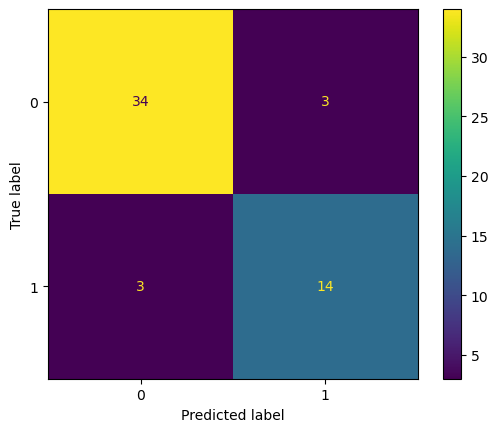

In [47]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm_rf).plot();

In [48]:
class_report = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        37
           1       0.82      0.82      0.82        17

    accuracy                           0.89        54
   macro avg       0.87      0.87      0.87        54
weighted avg       0.89      0.89      0.89        54



In [49]:
feature_importance = rf_best.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Descending Order):")
print(tabulate(feature_importance_df, headers='keys', tablefmt='grid', showindex=False))


Feature Importance (Descending Order):
+----------------------+--------------+
| Feature              |   Importance |
+======================+==============+
| Follicle No. (R)     |   0.238943   |
+----------------------+--------------+
| Follicle No. (L)     |   0.233346   |
+----------------------+--------------+
| Skin darkening (Y/N) |   0.142275   |
+----------------------+--------------+
| Weight gain(Y/N)     |   0.0784502  |
+----------------------+--------------+
| hair growth(Y/N)     |   0.0580545  |
+----------------------+--------------+
| Fast food (Y/N)      |   0.0395541  |
+----------------------+--------------+
| Cycle length(days)   |   0.0393653  |
+----------------------+--------------+
| Hip(inch)            |   0.0230908  |
+----------------------+--------------+
| Age (yrs)            |   0.0212404  |
+----------------------+--------------+
| Weight (Kg)          |   0.0198549  |
+----------------------+--------------+
| BMI                  |   0.0168705  |


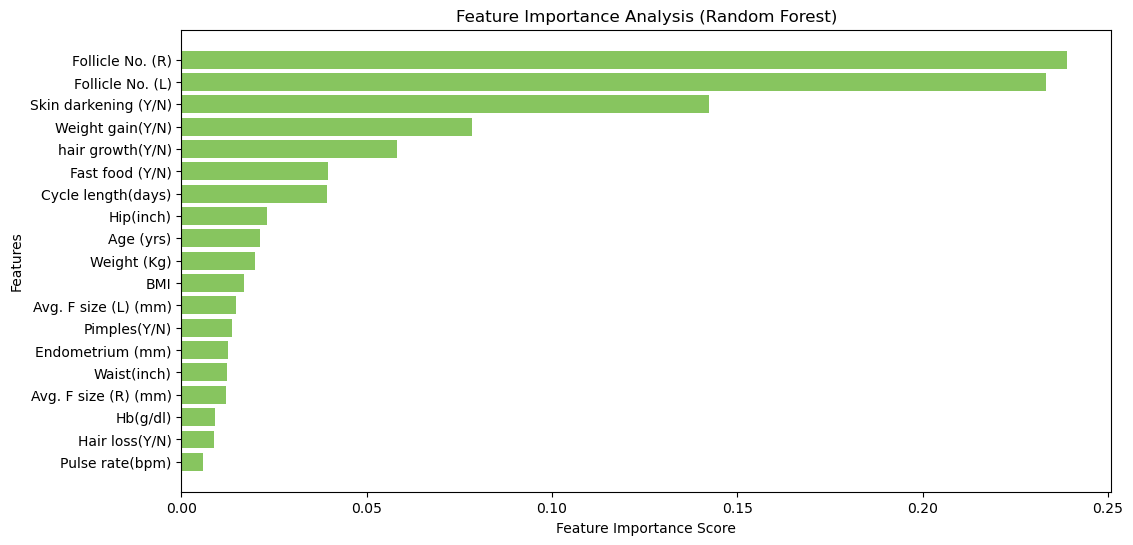

In [50]:
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#87c55f')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Analysis (Random Forest)')
plt.gca().invert_yaxis()  # 
plt.show()

## Logistic Regression

In [51]:
# Apply 50-fold Cross-Validation within the 80% training set
kf = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

In [52]:
logreg = LogisticRegression(random_state=16, max_iter=5000)
cv_scores = cross_val_score(logreg, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Baseline Mean Accuracy from 50-fold CV: {np.mean(cv_scores):.4f}")

Baseline Mean Accuracy from 50-fold CV: 0.8978


In [53]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # L1 (Lasso) or L2 (Ridge)
    'solver': ['liblinear', 'saga']  # Solvers that support L1/L2 regularization
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000, random_state=16),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=2)

In [54]:
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


In [55]:
logreg_best = LogisticRegression(**best_params, random_state=16, max_iter=5000)
logreg_best.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=5000, penalty='l1', random_state=16,
                   solver='saga')

In [56]:
y_pred_lr = logreg_best.predict(X_test)
y_prob_lr = logreg_best.predict_proba(X_test)[:, 1]

In [57]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

In [58]:
results = [
    ["Accuracy", f"{accuracy_lr:.2f}"],
    ["Precision", f"{precision_lr:.2f}"],
    ["Recall", f"{recall_lr:.2f}"],
    ["F1-Score", f"{f1_lr:.2f}"],
    ["AUC-ROC", f"{roc_auc_lr:.2f}"]
]

print("\nFinal Logistic Regression Performance Metrics:")
print(tabulate(results, headers=["Metric", "Score"], tablefmt="grid"))


Final Logistic Regression Performance Metrics:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |    0.87 |
+-----------+---------+
| Precision |    0.81 |
+-----------+---------+
| Recall    |    0.76 |
+-----------+---------+
| F1-Score  |    0.79 |
+-----------+---------+
| AUC-ROC   |    0.89 |
+-----------+---------+


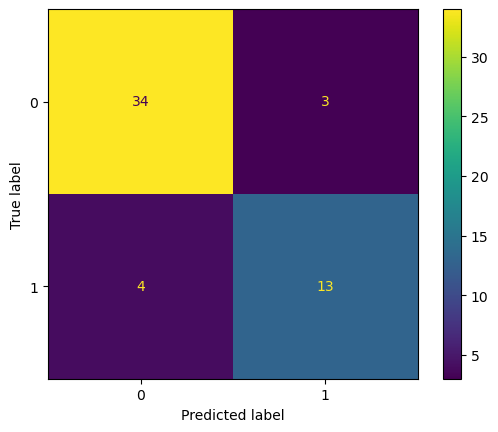

In [59]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm_lr).plot();

In [60]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        37
           1       0.81      0.76      0.79        17

    accuracy                           0.87        54
   macro avg       0.85      0.84      0.85        54
weighted avg       0.87      0.87      0.87        54



In [61]:
feature_importance = logreg_best.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': feature_importance
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression Feature Importance:")
print(tabulate(feature_importance_df, headers='keys', tablefmt='grid', showindex=False))


Logistic Regression Feature Importance:
+----------------------+---------------+
| Feature              |   Coefficient |
+======================+===============+
| Follicle No. (R)     |     1.17278   |
+----------------------+---------------+
| Skin darkening (Y/N) |     0.976173  |
+----------------------+---------------+
| hair growth(Y/N)     |     0.639418  |
+----------------------+---------------+
| Weight gain(Y/N)     |     0.632509  |
+----------------------+---------------+
| Follicle No. (L)     |     0.517632  |
+----------------------+---------------+
| Endometrium (mm)     |     0.101763  |
+----------------------+---------------+
| Pimples(Y/N)         |     0.0210909 |
+----------------------+---------------+
| Age (yrs)            |     0         |
+----------------------+---------------+
| Weight (Kg)          |     0         |
+----------------------+---------------+
| BMI                  |     0         |
+----------------------+---------------+
| Fast food (Y/N

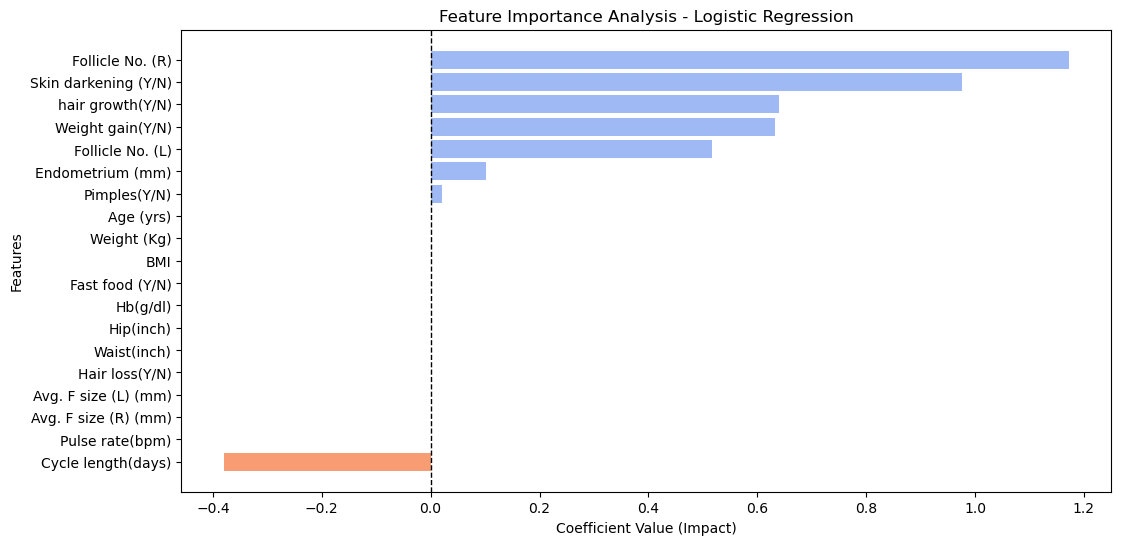

In [62]:
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'], color=['#9eb9f3' if c > 0 else '#f89c74' for c in feature_importance_df['Coefficient']])
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Coefficient Value (Impact)')
plt.ylabel('Features')
plt.title('Feature Importance Analysis - Logistic Regression')
plt.gca().invert_yaxis() 
plt.show()

**Interpretation:** \
Blue bars → Features that increase the likelihood of PCOS (positive coefficients).\
Orange bars → Features that decrease the likelihood of PCOS (negative coefficients).

## Support Vector Machine

In [63]:
# Apply 50-fold Cross-Validation within the 80% training set
kf = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

In [64]:
svm_model = SVC(kernel='linear', probability=True, random_state=16)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Baseline Mean Accuracy from 50-fold CV (SVM): {np.mean(cv_scores):.4f}")

Baseline Mean Accuracy from 50-fold CV (SVM): 0.9028


In [65]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel functions
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

grid_search = GridSearchCV(SVC(probability=True, random_state=16), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=16), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [66]:
best_params = grid_search.best_params_
print(f"Best Hyperparameters (SVM): {best_params}")

Best Hyperparameters (SVM): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [67]:
svm_best = SVC(**best_params, probability=True, random_state=16)
svm_best.fit(X_train, y_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=16)

In [68]:
y_pred_svm = svm_best.predict(X_test)
y_prob_svm = svm_best.predict_proba(X_test)[:, 1]

In [69]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_prob_svm)

In [70]:
# Step 6: Print Performance Metrics
results = [
    ["Accuracy", f"{accuracy_svm:.2f}"],
    ["Precision", f"{precision_svm:.2f}"],
    ["Recall", f"{recall_svm:.2f}"],
    ["F1-Score", f"{f1_svm:.2f}"],
    ["AUC-ROC", f"{roc_auc_svm:.2f}"]
]

print("\nFinal SVM Performance Metrics:")
print(tabulate(results, headers=["Metric", "Score"], tablefmt="grid"))


Final SVM Performance Metrics:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |    0.83 |
+-----------+---------+
| Precision |    0.75 |
+-----------+---------+
| Recall    |    0.71 |
+-----------+---------+
| F1-Score  |    0.73 |
+-----------+---------+
| AUC-ROC   |    0.92 |
+-----------+---------+


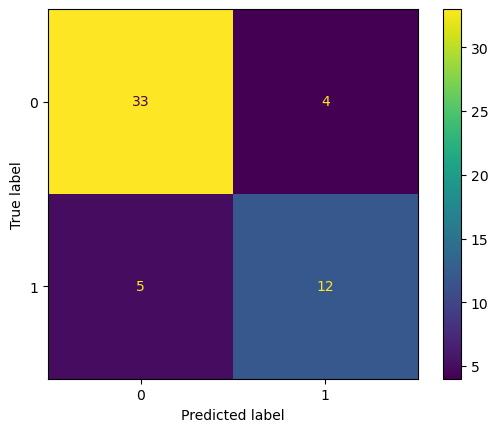

In [71]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot();

In [72]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        37
           1       0.75      0.71      0.73        17

    accuracy                           0.83        54
   macro avg       0.81      0.80      0.80        54
weighted avg       0.83      0.83      0.83        54



In [73]:
perm_importance = permutation_importance(svm_best, X_test, y_test, n_repeats=30, random_state=42)

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nSupport Vector Machine Feature Importance:")
print(tabulate(feature_importance_df, headers='keys', tablefmt='grid', showindex=False))


Support Vector Machine Feature Importance:
+----------------------+--------------+
| Feature              |   Importance |
+======================+==============+
| Follicle No. (R)     |  0.0740741   |
+----------------------+--------------+
| hair growth(Y/N)     |  0.0037037   |
+----------------------+--------------+
| Age (yrs)            |  0.00123457  |
+----------------------+--------------+
| Pulse rate(bpm)      |  0.000617284 |
+----------------------+--------------+
| Avg. F size (R) (mm) |  0.000617284 |
+----------------------+--------------+
| Hair loss(Y/N)       |  0           |
+----------------------+--------------+
| Fast food (Y/N)      |  0           |
+----------------------+--------------+
| Weight (Kg)          |  0           |
+----------------------+--------------+
| Skin darkening (Y/N) | -0.00246914  |
+----------------------+--------------+
| Hb(g/dl)             | -0.00308642  |
+----------------------+--------------+
| Hip(inch)            | -0.00617284

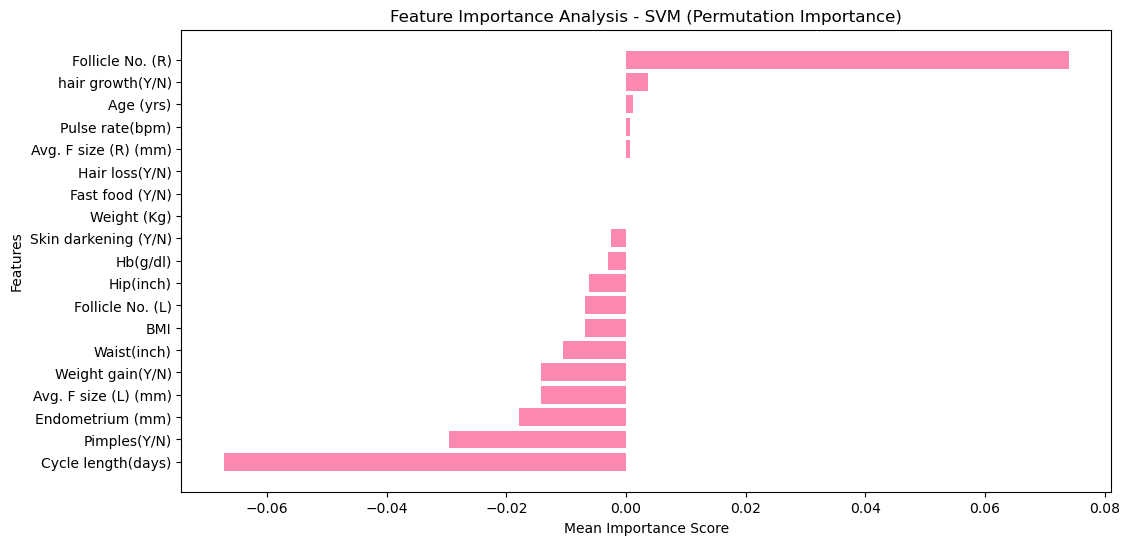

In [74]:
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#fe88b1')
plt.xlabel('Mean Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Analysis - SVM (Permutation Importance)')
plt.gca().invert_yaxis() 
plt.show()

## Gradient Boosting

In [75]:
# Apply 50-fold Cross-Validation within the 80% training set
kf = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

In [76]:
gb_model = GradientBoostingClassifier(random_state=16)
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=kf, scoring='accuracy')

print(f"Baseline Mean Accuracy from 50-fold CV (Gradient Boosting): {np.mean(cv_scores):.4f}")

Baseline Mean Accuracy from 50-fold CV (Gradient Boosting): 0.8953


In [77]:
gb_param_grid = {
    'n_estimators': [30, 50, 75],  # Reduce number of trees
    'learning_rate': [0.001, 0.005, 0.01],  # Very slow learning rate
    'max_depth': [2, 3],  # Extremely shallow trees
    'min_samples_split': [10, 15, 20],  # More samples required to split
    'min_samples_leaf': [5, 10],  # Larger leaf size for better generalization
    'subsample': [0.5, 0.6],  # Reduce data usage per tree to prevent overfitting
    'max_features': ['sqrt']  # Use only a fraction of features per tree
}

gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=16),
                              gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
gb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=16),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.005, 0.01],
                         'max_depth': [2, 3], 'max_features': ['sqrt'],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [30, 50, 75],
                         'subsample': [0.5, 0.6]},
             scoring='accuracy', verbose=2)

In [78]:
gb_best_params = gb_grid_search.best_params_
print(f"Best Hyperparameters for Gradient Boosting: {gb_best_params}")

Best Hyperparameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 75, 'subsample': 0.5}


In [79]:
gb_best = GradientBoostingClassifier(**gb_best_params, random_state=16)
gb_best.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=15,
                           n_estimators=75, random_state=16, subsample=0.5)

In [80]:
y_pred_gb = gb_best.predict(X_test)
y_prob_gb = gb_best.predict_proba(X_test)[:, 1]

In [81]:
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

In [82]:
results = [
    ["Accuracy", f"{accuracy_gb:.2f}"],
    ["Precision", f"{precision_gb:.2f}"],
    ["Recall", f"{recall_gb:.2f}"],
    ["F1-Score", f"{f1_gb:.2f}"],
    ["AUC-ROC", f"{roc_auc_gb:.2f}"]
]

print("\nFinal Gradient Boosting Performance Metrics:")
print(tabulate(results, headers=["Metric", "Score"], tablefmt="grid"))


Final Gradient Boosting Performance Metrics:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |    0.87 |
+-----------+---------+
| Precision |    1    |
+-----------+---------+
| Recall    |    0.59 |
+-----------+---------+
| F1-Score  |    0.74 |
+-----------+---------+
| AUC-ROC   |    0.91 |
+-----------+---------+


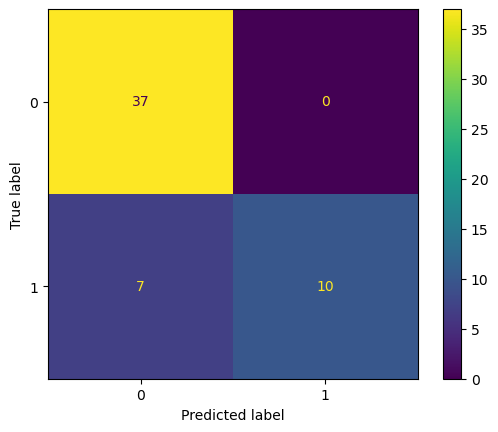

In [83]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
ConfusionMatrixDisplay(confusion_matrix=cm_gb).plot()

In [84]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        37
           1       1.00      0.59      0.74        17

    accuracy                           0.87        54
   macro avg       0.92      0.79      0.83        54
weighted avg       0.89      0.87      0.86        54



In [85]:
feature_importance = gb_best.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("\nGradient Boosting Feature Importance:")
print(tabulate(feature_importance_df, headers='keys', tablefmt='grid', showindex=False))


Gradient Boosting Feature Importance:
+----------------------+--------------+
| Feature              |   Importance |
+======================+==============+
| Follicle No. (R)     |  0.294299    |
+----------------------+--------------+
| Follicle No. (L)     |  0.214252    |
+----------------------+--------------+
| Weight gain(Y/N)     |  0.106215    |
+----------------------+--------------+
| Skin darkening (Y/N) |  0.0940204   |
+----------------------+--------------+
| Cycle length(days)   |  0.070958    |
+----------------------+--------------+
| hair growth(Y/N)     |  0.0544772   |
+----------------------+--------------+
| Fast food (Y/N)      |  0.0303556   |
+----------------------+--------------+
| Pimples(Y/N)         |  0.0225893   |
+----------------------+--------------+
| BMI                  |  0.0198428   |
+----------------------+--------------+
| Weight (Kg)          |  0.0144168   |
+----------------------+--------------+
| Age (yrs)            |  0.0135549   |
+

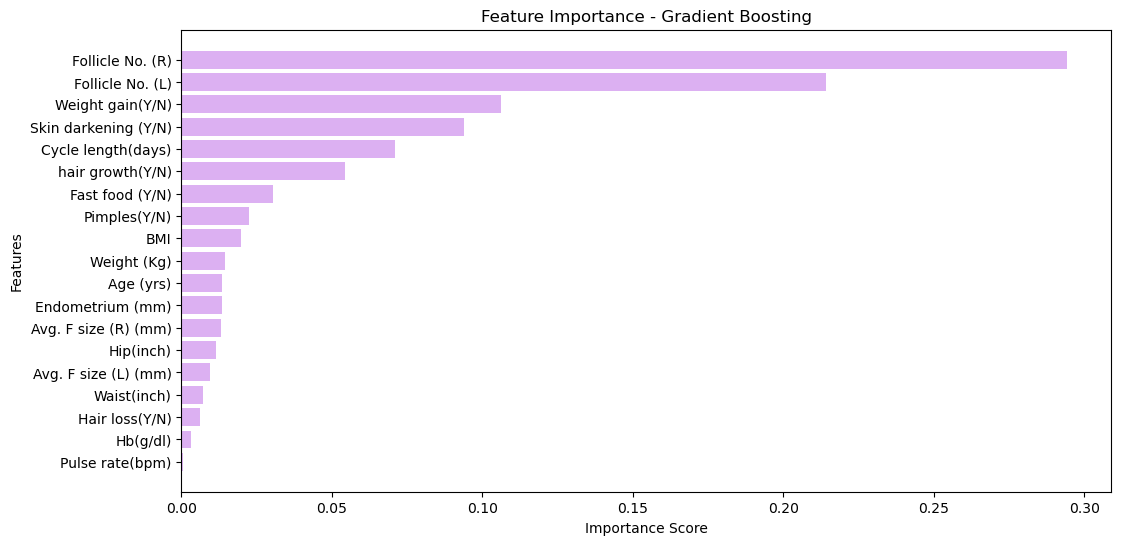

In [86]:
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#dcb0f2')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting')
plt.gca().invert_yaxis() 
plt.show()

## Convolutional Neural Network (CNN)

In [87]:
X_train_cnn = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

In [88]:
def create_cnn_model(learning_rate=0.001, filters1=64, filters2=128, dense_units=64, dropout_rate=0.3):
    model = Sequential([
        Conv1D(filters=filters1, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        Conv1D(filters=filters2, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(dropout_rate),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [89]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for train_index, val_index in kf.split(X_train_cnn):
    X_train_fold, X_val_fold = X_train_cnn[train_index], X_train_cnn[val_index]
    y_train_np = np.array(y_train)  # Convert Series to NumPy array
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    model = create_cnn_model()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train_fold, y_train_fold,
              epochs=50,
              batch_size=32,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping],
              verbose=0)

    val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
    cv_accuracies.append(val_accuracy)

print(f"Mean Cross-Validation Accuracy (CNN): {np.mean(cv_accuracies):.4f}")

Mean Cross-Validation Accuracy (CNN): 0.8819


In [90]:
model = create_cnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test_cnn, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6483 - loss: 0.8460 - val_accuracy: 0.5000 - val_loss: 0.6760
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8419 - loss: 0.4443 - val_accuracy: 0.7407 - val_loss: 0.6263
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8608 - loss: 0.3544 - val_accuracy: 0.7778 - val_loss: 0.5786
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8700 - loss: 0.3003 - val_accuracy: 0.7778 - val_loss: 0.5365
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8776 - loss: 0.2934 - val_accuracy: 0.8333 - val_loss: 0.4985
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8935 - loss: 0.2525 - val_accuracy: 0.7963 - val_loss: 0.4754
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9061 - loss: 0.2392 - val_accuracy: 0.7963 - val_loss: 0.4641
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8763 - loss: 0.2580 - val_accuracy: 0.8148 - 

In [91]:
y_pred_cnn = (model.predict(X_test_cnn) > 0.5).astype(int)
y_prob_cnn = model.predict(X_test_cnn).ravel()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [92]:
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)
roc_auc_cnn = roc_auc_score(y_test, y_prob_cnn)

In [93]:
results = [
    ["Accuracy", f"{accuracy_cnn:.2f}"],
    ["Precision", f"{precision_cnn:.2f}"],
    ["Recall", f"{recall_cnn:.2f}"],
    ["F1-Score", f"{f1_cnn:.2f}"],
    ["AUC-ROC", f"{roc_auc_cnn:.2f}"]
]

print("\nFinal CNN Performance Metrics:")
print(tabulate(results, headers=["Metric", "Score"], tablefmt="grid"))


Final CNN Performance Metrics:
+-----------+---------+
| Metric    |   Score |
+===========+=========+
| Accuracy  |    0.89 |
+-----------+---------+
| Precision |    0.92 |
+-----------+---------+
| Recall    |    0.71 |
+-----------+---------+
| F1-Score  |    0.8  |
+-----------+---------+
| AUC-ROC   |    0.88 |
+-----------+---------+


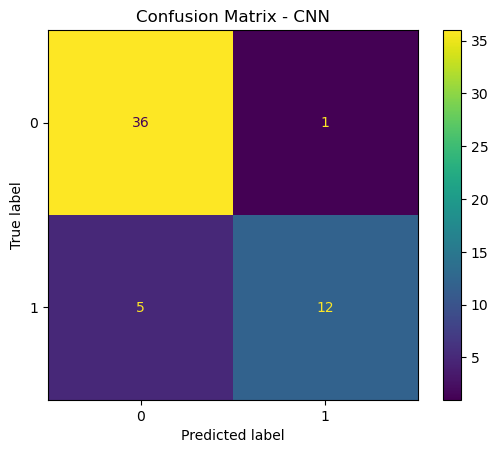

In [94]:
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
ConfusionMatrixDisplay(confusion_matrix=cnf_matrix).plot()
plt.title("Confusion Matrix - CNN")
plt.show()

In [95]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cnn))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        37
           1       0.92      0.71      0.80        17

    accuracy                           0.89        54
   macro avg       0.90      0.84      0.86        54
weighted avg       0.89      0.89      0.88        54



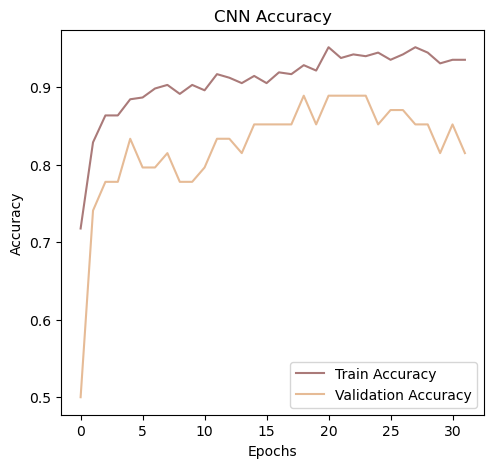

In [96]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#aa7a79')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#e6bb96')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

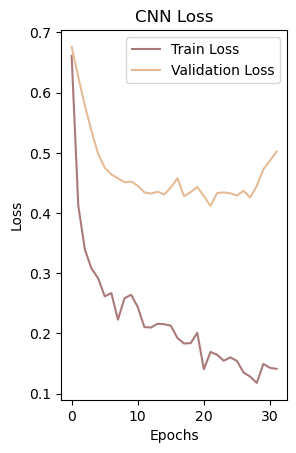

In [97]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#aa7a79')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#e6bb96')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [98]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 17, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 17, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 6, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,533 (588.02 KB)

 Trainable params: 50,049 (195.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 100,100 (391.02 KB)

# Model Comparison

In [99]:
final_results = {
    "Model": ["Random Forest", "Logistic Regression", "SVM", "Gradient Boosting", "CNN"],
    "Accuracy": [round(accuracy_rf, 2), round(accuracy_lr, 2), round(accuracy_svm, 2), round(accuracy_gb, 2), round(accuracy_cnn, 2)],
    "Precision": [round(precision_rf, 2), round(precision_lr, 2), round(precision_svm, 2), round(precision_gb, 2), round(precision_cnn, 2)],
    "Recall": [round(recall_rf, 2), round(recall_lr, 2), round(recall_svm, 2), round(recall_gb, 2), round(recall_cnn, 2)],
    "F1-Score": [round(f1_rf, 2), round(f1_lr, 2), round(f1_svm, 2), round(f1_gb, 2), round(f1_cnn, 2)],
    "AUC-ROC": [round(roc_auc_rf, 2), round(roc_auc_lr, 2), round(roc_auc_svm, 2), round(roc_auc_gb, 2), round(roc_auc_cnn, 2)]
}

final_results_df = pd.DataFrame(final_results)

print("\nFinal Performance Comparison of All Models:")
print(tabulate(final_results_df, headers='keys', tablefmt='grid'))


Final Performance Comparison of All Models:
+----+---------------------+------------+-------------+----------+------------+-----------+
|    | Model               |   Accuracy |   Precision |   Recall |   F1-Score |   AUC-ROC |
+====+=====================+============+=============+==========+============+===========+
|  0 | Random Forest       |       0.89 |        0.82 |     0.82 |       0.82 |      0.9  |
+----+---------------------+------------+-------------+----------+------------+-----------+
|  1 | Logistic Regression |       0.87 |        0.81 |     0.76 |       0.79 |      0.89 |
+----+---------------------+------------+-------------+----------+------------+-----------+
|  2 | SVM                 |       0.83 |        0.75 |     0.71 |       0.73 |      0.92 |
+----+---------------------+------------+-------------+----------+------------+-----------+
|  3 | Gradient Boosting   |       0.87 |        1    |     0.59 |       0.74 |      0.91 |
+----+---------------------+-------

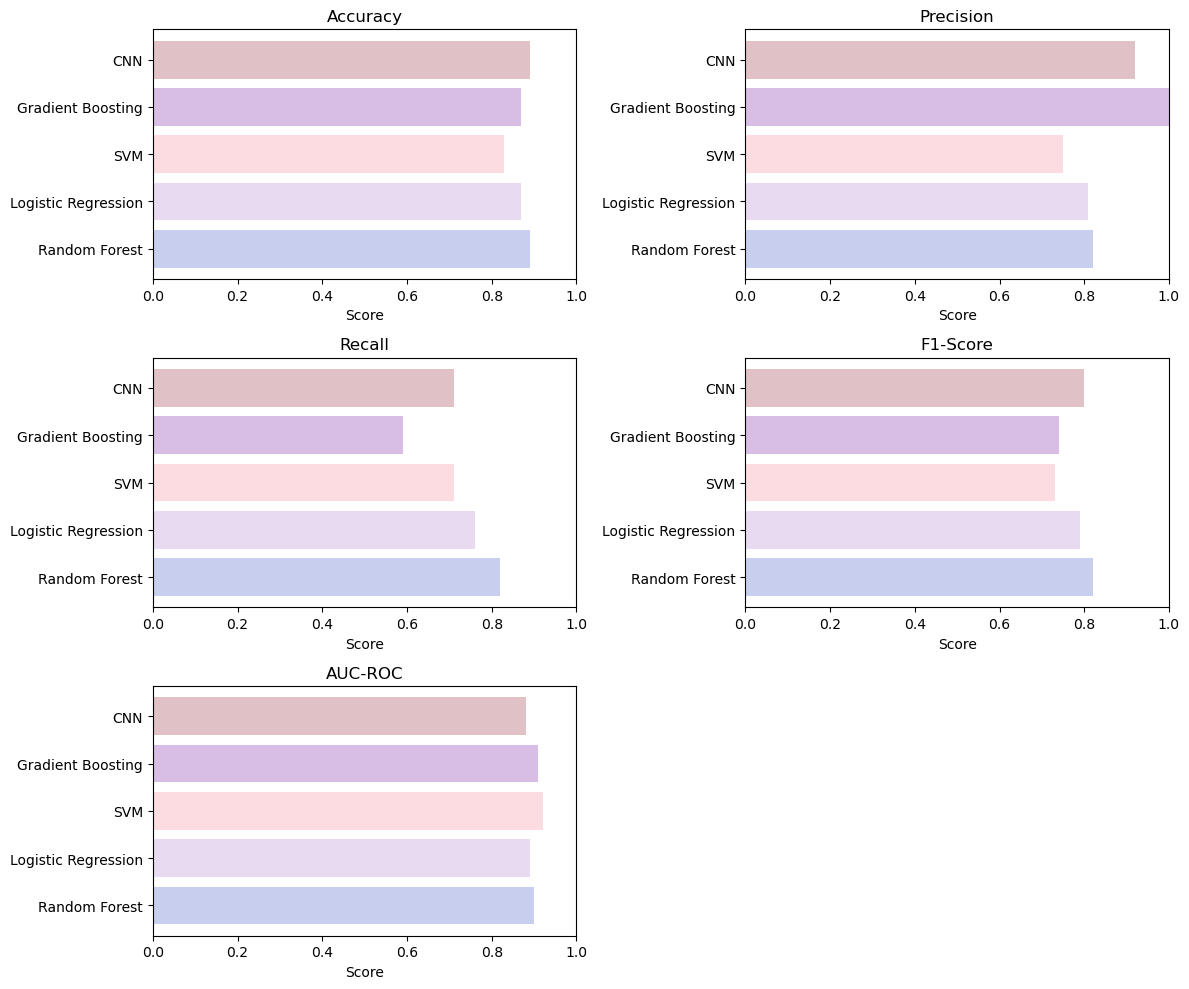

In [100]:
plt.figure(figsize=(12, 10))

metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    plt.barh(final_results_df["Model"], final_results_df[metric], color=['#c8ceee', '#e8daf0', '#fcdce1', '#d8bee5', '#e0c1c6'])
    plt.title(metric)
    plt.xlabel("Score")
    plt.xlim(0, 1)

plt.tight_layout()
plt.show()

## Train vs Test Accuracy for Overfitting Check

In [101]:
train_accuracy = [
    round(rf_best.score(X_train, y_train), 2), 
    round(logreg_best.score(X_train, y_train), 2), 
    round(svm_best.score(X_train, y_train), 2), 
    round(gb_best.score(X_train, y_train), 2), 
    round(model.evaluate(X_train_cnn, y_train, verbose=0)[1], 2)  # CNN train accuracy
]

test_accuracy = [round(accuracy_rf, 2), round(accuracy_lr, 2), round(accuracy_svm, 2), round(accuracy_gb, 2), round(accuracy_cnn, 2)]
accuracy_diff = [round(train - test, 2) for train, test in zip(train_accuracy, test_accuracy)]

overfitting_status = ["⚠️ Overfitting! Needs tuning" if diff > 0.10 else "✅ Good Generalization" for diff in accuracy_diff]
overfit_results_df = pd.DataFrame({
    "Model": ["Random Forest", "Logistic Regression", "SVM", "Gradient Boosting", "CNN"],
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Accuracy Gap": accuracy_diff,
    "Overfitting Status": overfitting_status
})

print("\nTrain vs. Test Accuracy Comparison (Overfitting Check):")
print(tabulate(overfit_results_df, headers='keys', tablefmt='grid'))


Train vs. Test Accuracy Comparison (Overfitting Check):
+----+---------------------+------------------+-----------------+----------------+------------------------+
|    | Model               |   Train Accuracy |   Test Accuracy |   Accuracy Gap | Overfitting Status     |
+====+=====================+==================+=================+================+========================+
|  0 | Random Forest       |             0.94 |            0.89 |           0.05 | ✅ Good Generalization |
+----+---------------------+------------------+-----------------+----------------+------------------------+
|  1 | Logistic Regression |             0.93 |            0.87 |           0.06 | ✅ Good Generalization |
+----+---------------------+------------------+-----------------+----------------+------------------------+
|  2 | SVM                 |             0.92 |            0.83 |           0.09 | ✅ Good Generalization |
+----+---------------------+------------------+-----------------+----------------+

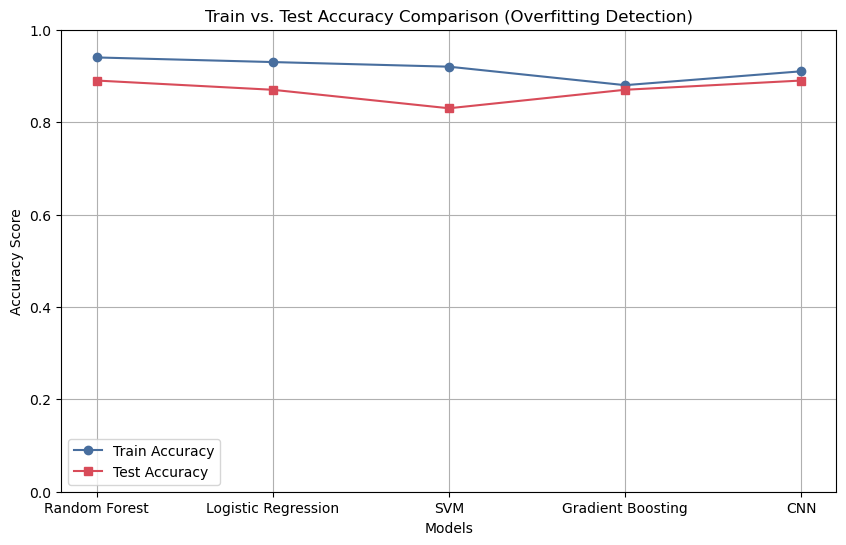

In [102]:
plt.figure(figsize=(10, 6))

x = overfit_results_df["Model"]
train_acc = overfit_results_df["Train Accuracy"]
test_acc = overfit_results_df["Test Accuracy"]
accuracy_gap = overfit_results_df["Accuracy Gap"]

plt.plot(x, train_acc, marker='o', linestyle='-', color='#486e9e', label="Train Accuracy")
plt.plot(x, test_acc, marker='s', linestyle='-', color='#d84b59', label="Test Accuracy")

for i, gap in enumerate(accuracy_gap):
    if gap > 0.10:
        plt.text(i, train_acc[i] + 0.02, "⚠️ Overfitting", fontsize=10, fontweight='bold', color="red")

plt.xlabel("Models")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1) 
plt.title("Train vs. Test Accuracy Comparison (Overfitting Detection)")
plt.legend()
plt.grid(True)
plt.show()

# Results and Discussion

1. Random Forest (RF) 
    * Accuracy: 89%, Precision: 82%, Recall: 82%, F1-Score: 82%, AUC-ROC: 90%
    * Balanced classification with minimal false positives/negatives.
    * Strong recall (82%) makes it effective in detecting PCOS cases.
    * Feature importance highlights follicle count of both ovaries, weight gain, and skin darkening as key predictors. <br></br>
      
    The model performed well with high accuracy (89%) and recall (82%), making it highly effective for detecting PCOS cases. The feature importance analysis aligns with clinical expectations, highlighting key risk factors. While it balances precision and recall well, further optimization could focus on reducing misclassifications.

2. Logistic Regression (LR) 
    * Accuracy: 87%, Precision: 81%, Recall: 76%, F1-Score: 79%, AUC-ROC: 89%
    * Slightly lower recall (76%) compared to RF, leading to more false negatives.
    * Provides interpretability but lacks the ability to capture complex feature interactions.
    * Follicle count of both ovaries, skin darkening, and cycle length emerged as significant predictors. <br></br>

    Despite being a simpler model, Logistic Regression demonstrated strong interpretability with an accuracy of 87%. However, its recall (76%) is lower than RF, meaning more PCOS cases could be missed. Enhancing feature selection and adjusting classification thresholds could improve its sensitivity.

3. Support Vector Machine (SVM) 
    * Accuracy: 83%, Precision: 75%, Recall: 71%, F1-Score: 73%, AUC-ROC: 92%
    * Lowest recall (71%) among models, missing more PCOS cases.
    * Performs well in distinguishing between classes (AUC-ROC: 92%).
    * Key predictors include follicle count of right ovary, hair growth, and cycle length. <br></br>

    SVM achieved an accuracy of 83% but struggled with recall (71%), missing several PCOS cases. It performed well in distinguishing classes (AUC-ROC: 92%), but optimizing hyperparameters or integrating additional predictive features could enhance sensitivity.

4. Gradient Boosting (GB) 
    * Accuracy: 87%, Precision: 100%, Recall: 59%, F1-Score: 74%, AUC-ROC: 91%
    * High precision but poor recall (59%), indicating a tendency to miss PCOS cases.
    * Feature importance aligns with other models, emphasizing follicle count of both ovaries, weight gain, and lifestyle factors. <br></br>

    While GB achieved perfect precision (100%), its recall (59%) was the lowest, meaning it missed many PCOS cases. The model favors specificity over sensitivity, which may not be ideal for medical diagnostics. Adjusting class weights or thresholds could improve recall while maintaining accuracy.

5. Convolutional Neural Network (CNN) 
    * Accuracy: 89%, Precision: 92%, Recall: 71%, F1-Score: 80%, AUC-ROC: 88%
    * High precision (92%) but recall (71%) remains a concern.
    * Overfitting detected, as training accuracy reached 94% while validation accuracy fluctuated (81-85%). <br></br>

    CNN performed well with high accuracy (89%) and precision (92%) but suffered from recall issues (71%) and overfitting. Reducing overfitting through regularization, data augmentation, or early stopping could enhance its generalization to unseen cases.

# Conclusion

* Top Performers: CNN and Random Forest achieved the highest accuracy (89%).
* Best Recall (Minimizing False Negatives): Random Forest (82%), making it the best for ensuring all PCOS cases are detected.
* Best Precision (Minimizing False Positives): Gradient Boosting (100%) and CNN (92%), ideal for reducing misdiagnosed cases.
* Most Balanced Model: Random Forest, with strong recall and overall stability.
* Overfitting Concerns: CNN showed signs of overfitting, requiring further optimization.

The choice of model depends on priorities—Random Forest is best for ensuring fewer missed diagnoses, while CNN offers higher precision. Future improvements may involve ensembling models, refining hyperparameters, or using techniques like SMOTE for handling class imbalances

For the UI implementation, CNN was chosen because it has one of the highest accuracy and best precision, which is essential for identifying PCOS (1) or non-PCOS (0) cases. While Random Forest (RF) achieved high accuracy (89%) and recall (82%), a Convolutional Neural Network (CNN) was chosen for deployment due to its superior precision (92%) and strong overall performance.

CNN excels in detecting complex feature interactions without manual feature engineering, making it well-suited for medical datasets. Unlike traditional models, which rely on predefined features, CNN learns intricate patterns automatically, improving predictive accuracy. Though its recall (71%) was lower than RF’s, this can be optimized using regularization, hyperparameter tuning, and class-balancing techniques.

Additionally, CNN offers long-term scalability and adaptability—as more data becomes available, its performance can improve, unlike traditional models, which may plateau. Advanced techniques like Grad-CAM also enhance interpretability, making CNN a practical choice for clinical applications.

Ultimately, CNN was selected because its high precision reduces misdiagnosed cases, while its deep learning capabilities allow for future improvements. Though RF had better recall, CNN’s ability to minimize false positives made it the most effective model for deployment.

***
***